
Initial Schedule at t=0 min
Best Headway: 10.88 min
Number of Metros: 7
Total Estimated Cost (BDT): 27815.87


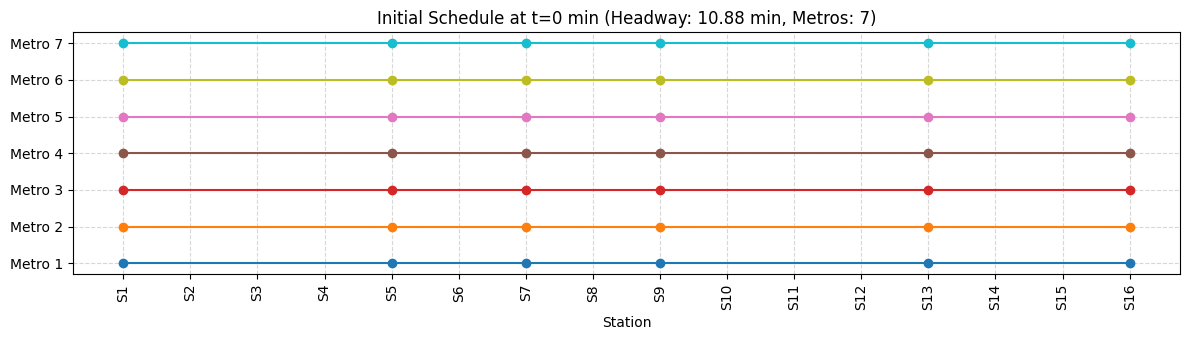

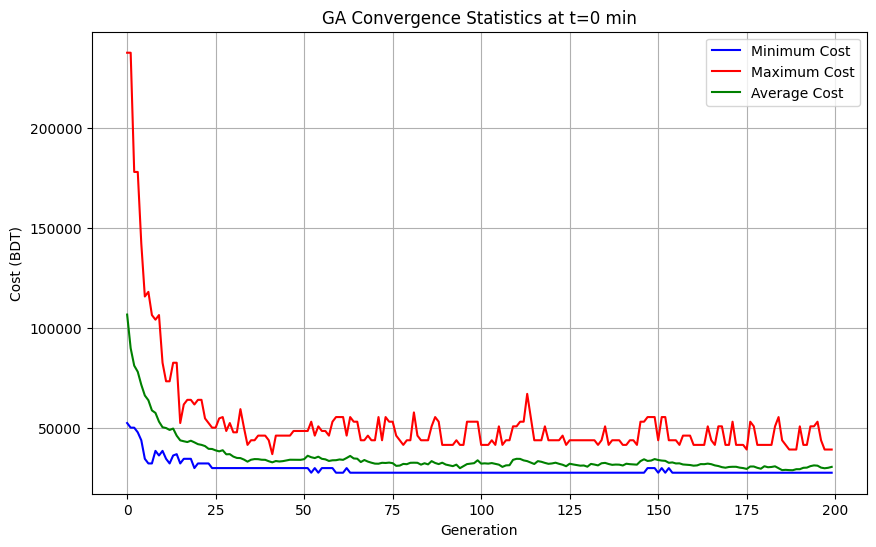


Demand changed significantly at t=5 min, re-running GA...

Updated Schedule at t=5 min
Updated Headway: 10.12 min
Updated Number of Metros: 7
Updated Estimated Cost (BDT): 23182.52


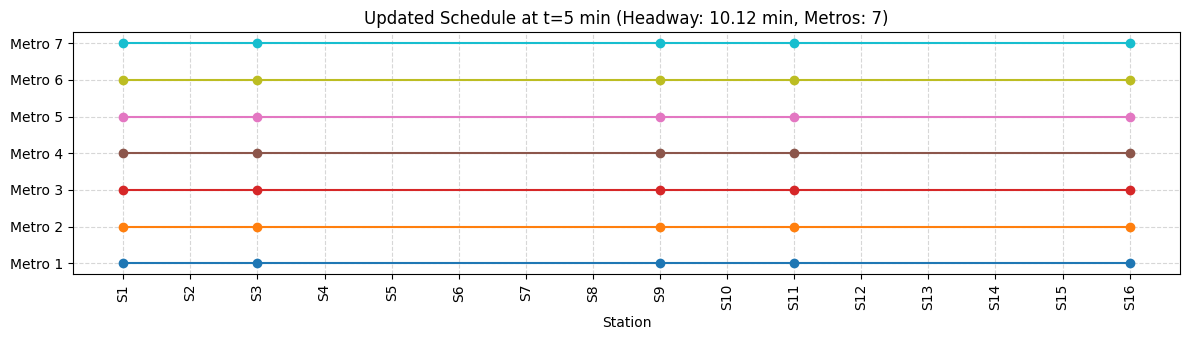

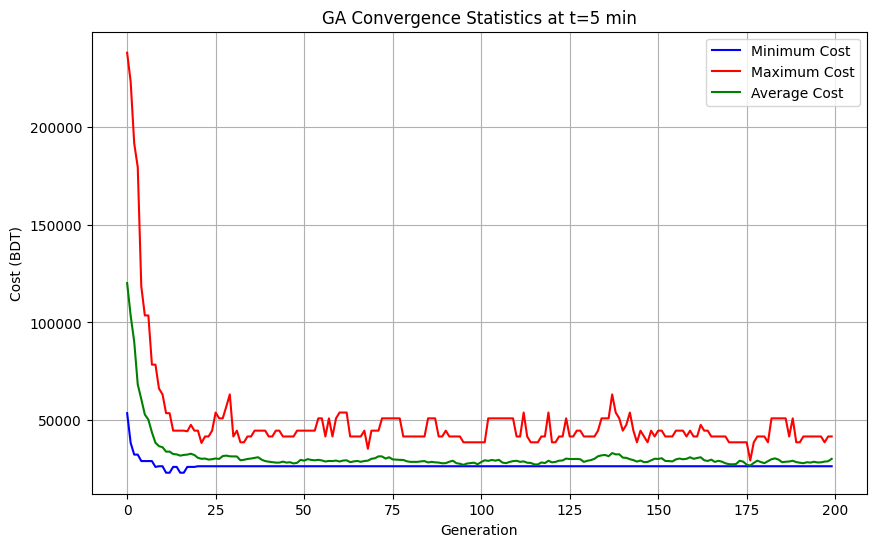


Demand changed significantly at t=10 min, re-running GA...

Updated Schedule at t=10 min
Updated Headway: 10.23 min
Updated Number of Metros: 8
Updated Estimated Cost (BDT): 29139.16


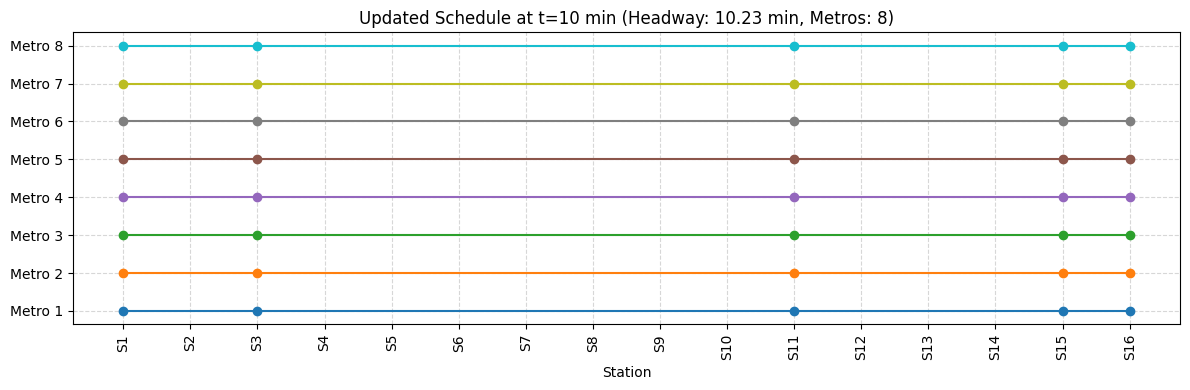

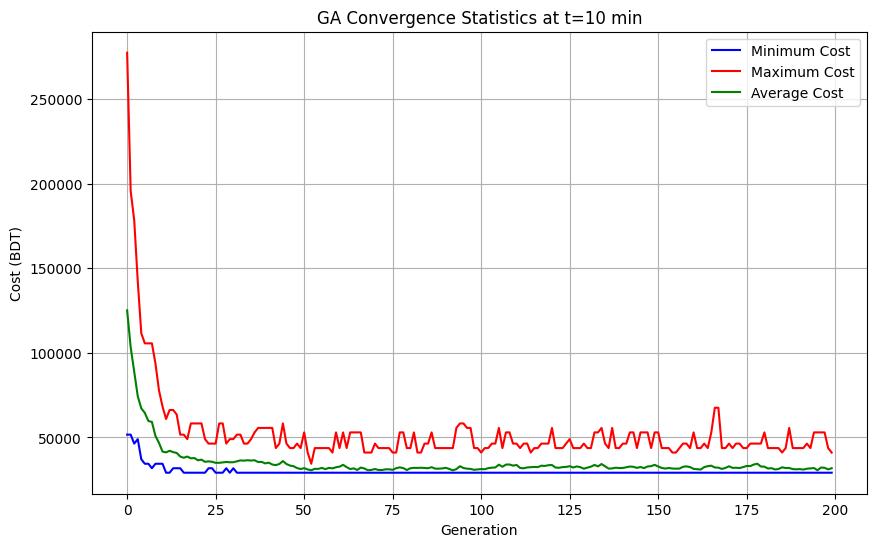


Demand changed significantly at t=15 min, re-running GA...

Updated Schedule at t=15 min
Updated Headway: 10.15 min
Updated Number of Metros: 7
Updated Estimated Cost (BDT): 30131.22


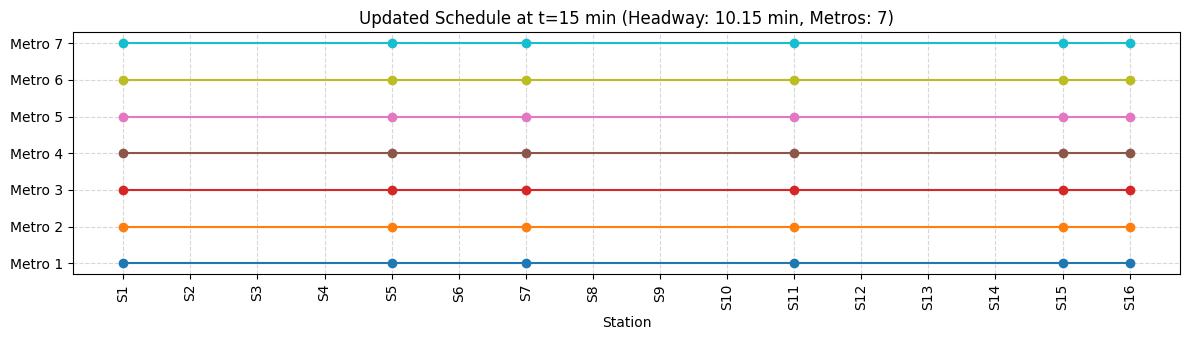

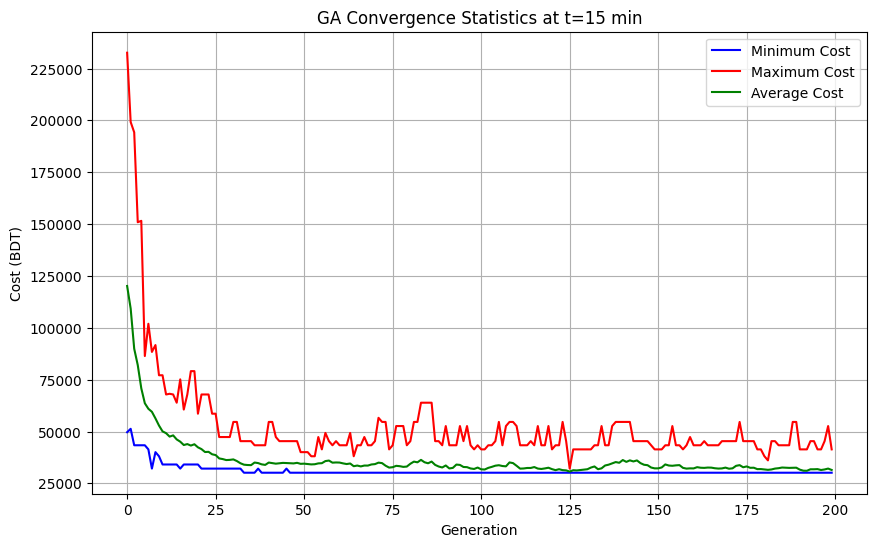


Demand changed significantly at t=20 min, re-running GA...

Updated Schedule at t=20 min
Updated Headway: 12.02 min
Updated Number of Metros: 7
Updated Estimated Cost (BDT): 27818.71


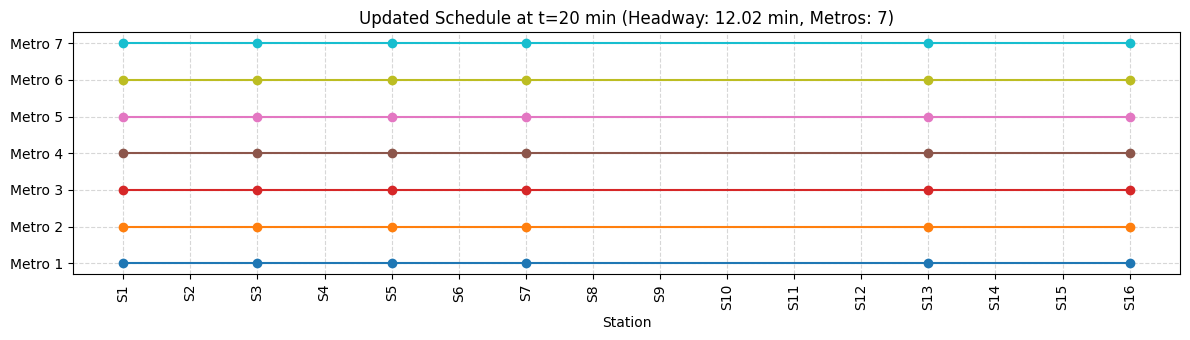

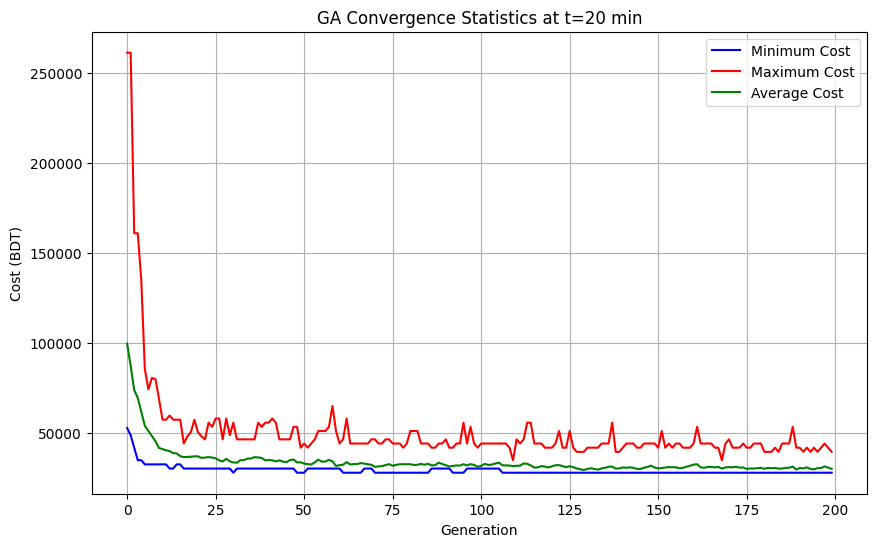


Demand changed significantly at t=25 min, re-running GA...


KeyboardInterrupt: 

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# SYSTEM PARAMETERS
# -----------------------

NUM_STOPS = 16
STOP_DISTANCES = [0.8] * (NUM_STOPS - 1)
DWELL_TIME = 1.0
ACC_DEC_TIME = 0.67
SPEED = 41
RUN_TIMES = [d / SPEED * 60 for d in STOP_DISTANCES]
# T is now the simulation time within each GA run, which will be the time difference between updates
HEADWAY_RANGE = (4, 15)

C1 = 5 # Cost parameter for waiting time Taka/Min
C2 = 2.75 # Cost parameter for in-vehicle time Taka/Min
C3 = 140 # Cost parameter for operation time Taka/Min

POP_SIZE = 50 # Increased population size for potentially better exploration
GENERATIONS = 200 # Increased generations for longer evolution
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1 # Increased mutation rate for more diversity

THRESHOLD_PERCENT_CHANGE = 0.15 # Reduced threshold for more frequent re-optimization
CHANGE_DETECTION_INTERVAL = 5 # Changed from 60 to 5

# T is the total simulation duration
T = 960 # 16 hours * 60 minutes/hour

SCHEDULE_TYPES = {'01': 'normal', '10': 'zone', '11': 'express'}

def generate_dynamic_station_loads(time):
    # Simulate peak and off-peak hours with some fluctuation
    peak = 400 if 240 <= time < 600 else 5000  # Peak from 4 hours to 10 hours (240-600 mins)
    offpeak = 0
    fluctuation = 1500 * np.sin(time / 60)
    return [max(800, int(np.random.normal(loc=peak if i % 2 == 0 else offpeak, scale=500) + fluctuation)) for i in range(NUM_STOPS)]


def detect_demand_change(prev, curr, threshold=THRESHOLD_PERCENT_CHANGE):
    for p, c in zip(prev, curr):
        if abs(c - p) / max(p, 1) > threshold:
            return True
    return False

def generate_od_matrix(loads, simulation_time):
    od = np.zeros((NUM_STOPS, NUM_STOPS))
    for i in range(NUM_STOPS):
        for j in range(NUM_STOPS):
            if i != j:
                od[i][j] = (loads[i] * loads[j]) / (abs(i - j) + 1)
    # Scale OD matrix based on the simulation time
    if np.sum(od) > 0:
        # Scale by the ratio of current simulation time interval to a reference period (e.g., 60 minutes)
        od *= 60 / np.sum(od) * (simulation_time / 60) # Scale based on the interval duration
    return od

def get_stop_patterns(loads):
    zone_threshold = np.percentile(loads, 50)
    express_threshold = np.percentile(loads, 80)
    zone = [1 if load >= zone_threshold else 0 for load in loads]
    express = [1 if load >= express_threshold else 0 for load in loads]
    zone[0] = zone[-1] = express[0] = express[-1] = 1
    return zone, express

def get_stop_pattern(schedule_type, zone_pattern, express_pattern):
    if schedule_type == '01': # Normal
        return [1] * NUM_STOPS
    elif schedule_type == '10': # Zone
        return zone_pattern
    elif schedule_type == '11': # Express
        return express_pattern
    return [0] * NUM_STOPS # Should not happen

def calculate_trip_time(pattern):
    travel_time = sum([RUN_TIMES[i] for i in range(NUM_STOPS-1) if pattern[i] and pattern[i+1]])
    dwell_time = sum([DWELL_TIME for stop in pattern if stop])
    acc_dec_time = sum([ACC_DEC_TIME * 2 for stop in pattern if stop]) # Accel and Decel at each stop
    return travel_time + dwell_time + acc_dec_time

def generate_chromosome(simulation_interval):
    headway = random.uniform(*HEADWAY_RANGE)
    approx_round_trip_time = 2 * NUM_STOPS * (np.mean(RUN_TIMES) + DWELL_TIME + 2 * ACC_DEC_TIME)
    metros = int(approx_round_trip_time / headway) if headway > 0 else 0
    metros = max(3, metros) if simulation_interval > 0 else 0  # Ensure at least 3 metros

    # Ensure at least one of each type if metros >= 3
    schedule = []
    base_types = list(SCHEDULE_TYPES.keys())
    if metros >= len(base_types):
        schedule.extend(base_types)
        for _ in range(metros - len(base_types)):
            schedule.append(random.choice(base_types))
        random.shuffle(schedule)
    else:
        # Not enough metros for all types — pick randomly
        schedule = [random.choice(base_types) for _ in range(metros)]

    return (headway, schedule)


def mutate(ch):
    h, s = ch
    if random.random() < 0.5:
        h += random.uniform(-0.2, 0.2)
        h = min(max(h, HEADWAY_RANGE[0]), HEADWAY_RANGE[1])
    if s and random.random() < MUTATION_RATE:
        metro_idx = random.randint(0, len(s) - 1)
        s[metro_idx] = random.choice(list(SCHEDULE_TYPES.keys()))
    return (h, s)

def crossover(p1, p2):
    h1, s1 = p1
    h2, s2 = p2
    new_headway = (h1 + h2) / 2
    min_len = min(len(s1), len(s2)) if s1 and s2 else 0
    if min_len > 0:
        point = random.randint(0, min_len)
        new_s = s1[:point] + s2[point:]
    else:
        new_s = s1 if s1 else s2 # Keep the non-empty schedule if one is empty
    return (new_headway, new_s)

def select(pop, scores):
    finite_scores = [s for s in scores if s != float('inf')]
    if not finite_scores or sum(1.0/s for s in finite_scores if s > 0) == 0:
        return random.choice(pop) # Return a random chromosome if no valid scores

    total = sum(1.0 / s for s in finite_scores if s > 0)
    probs = []
    for s in scores:
        if s != float('inf') and s > 0:
            probs.append((1.0 / s) / total)
        else:
            probs.append(0)

    if sum(probs) == 0: # Handle edge case where all valid scores are negative or zero (shouldn't happen with cost)
         return random.choice(pop)

    probs = np.array(probs) / np.sum(probs) # Normalize probabilities
    return pop[np.random.choice(len(pop), p=probs)]


def evaluate(ch, od_matrix, zone, express, simulation_interval):
    headway, schedule = ch
    metros = len(schedule)
    wait_cost = inveh_cost = oper_cost = 0

    if simulation_interval <= 0 or metros == 0:
        return float('inf')

    for stop in range(NUM_STOPS):
        # Calculate arrival rate at the stop based on the OD matrix and interval duration
        # Assuming uniform arrivals within the interval for simplification
        arrival_rate = sum(od_matrix[i][stop] for i in range(NUM_STOPS) if i != stop) / simulation_interval if simulation_interval > 0 else 0
        wait_cost += C1 * arrival_rate * (headway / 2) if headway > 0 else float('inf') # Waiting time is headway/2

    for sched in schedule:
        pattern = get_stop_pattern(sched, zone, express)
        trip_time = calculate_trip_time(pattern)
        inveh_cost += C2 * trip_time
        oper_cost += C3 * trip_time * 2 # Round trip operation cost

    return wait_cost + inveh_cost + oper_cost

def run_ga(od_matrix, zone, express, simulation_interval):
    pop = [generate_chromosome(simulation_interval) for _ in range(POP_SIZE)]
    best_sol = None
    best_score = float('inf')
    history = [] # To store the best score of each generation
    all_scores_per_gen = [] # To store scores of all individuals in each generation

    for gen in range(GENERATIONS):
        scores = [evaluate(ch, od_matrix, zone, express, simulation_interval) for ch in pop]
        all_scores_per_gen.append(scores)
        next_gen = []
        for _ in range(POP_SIZE):
            p1 = select(pop, scores)
            p2 = select(pop, scores)

            if random.random() < CROSSOVER_RATE:
                child = crossover(p1, p2)
            else:
                child = random.choice([p1, p2])

            child = mutate(child)
            next_gen.append(child)

        pop = next_gen
        gen_best = min(pop, key=lambda ch: evaluate(ch, od_matrix, zone, express, simulation_interval))
        gen_score = evaluate(gen_best, od_matrix, zone, express, simulation_interval)
        history.append(gen_score)
        if gen_score < best_score:
            best_sol = gen_best
            best_score = gen_score

    # Prepare data for the new convergence plot
    min_scores = [min(s) for s in all_scores_per_gen if s]
    max_scores = [max(s) for s in all_scores_per_gen if s]
    avg_scores = [sum(s)/len(s) if s else 0 for s in all_scores_per_gen]


    return best_sol, best_score, history, min_scores, max_scores, avg_scores


def visualize_schedule(chromosome, zone, express, title):
    headway, schedule = chromosome
    if not schedule:
        print("No schedule to visualize.")
        return

    fig, ax = plt.subplots(figsize=(12, 0.5 * len(schedule)))
    colors = plt.colormaps['tab10'](np.linspace(0, 1, len(schedule)))

    for i, sched_type in enumerate(schedule):
        pattern = get_stop_pattern(sched_type, zone, express)
        stops = [idx for idx, stop in enumerate(pattern) if stop]
        if stops:
            ax.plot(stops, [i] * len(stops), 'o-', markersize=6, color=colors[i % len(colors)]) # Use modulo for color cycling

    ax.set_yticks(range(len(schedule)))
    ax.set_yticklabels([f"Metro {i+1}" for i in range(len(schedule))])
    ax.set_xticks(range(NUM_STOPS))
    ax.set_xticklabels([f"S{i+1}" for i in range(NUM_STOPS)], rotation=90) # Start station labels from S1
    ax.set_xlabel("Station")
    ax.set_title(f"{title} (Headway: {round(headway, 2)} min, Metros: {len(schedule)})")
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_ga_convergence_stats(min_scores, max_scores, avg_scores, title="GA Convergence Statistics"):
    plt.figure(figsize=(10, 6))
    generations = range(len(min_scores))
    plt.plot(generations, min_scores, label='Minimum Cost', color='blue')
    plt.plot(generations, max_scores, label='Maximum Cost', color='red')
    plt.plot(generations, avg_scores, label='Average Cost', color='green')
    plt.xlabel("Generation")
    plt.ylabel("Cost (BDT)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def run_dynamic_simulation():
    current_time = 0
    current_loads = generate_dynamic_station_loads(current_time)

    # Initial GA run
    simulation_interval = CHANGE_DETECTION_INTERVAL
    zone, express = get_stop_patterns(current_loads)
    od_matrix = generate_od_matrix(current_loads, simulation_interval)
    best, score, history, min_scores, max_scores, avg_scores = run_ga(od_matrix, zone, express, simulation_interval)
    print(f"\nInitial Schedule at t={current_time} min")
    print("Best Headway:", round(best[0], 2), "min")
    print("Number of Metros:", len(best[1]))
    print("Total Estimated Cost (BDT):", round(score, 2))
    visualize_schedule(best, zone, express, f"Initial Schedule at t={current_time} min")
    plot_ga_convergence_stats(min_scores, max_scores, avg_scores, f"GA Convergence Statistics at t={current_time} min")


    current_time += CHANGE_DETECTION_INTERVAL

    # Run GA for subsequent intervals if demand changes
    while current_time <= T:
        new_loads = generate_dynamic_station_loads(current_time)

        if detect_demand_change(current_loads, new_loads):
            print(f"\nDemand changed significantly at t={current_time} min, re-running GA...")
            current_loads = new_loads
            simulation_interval = CHANGE_DETECTION_INTERVAL
            zone, express = get_stop_patterns(current_loads)
            od_matrix = generate_od_matrix(current_loads, simulation_interval)
            best, score, history, min_scores, max_scores, avg_scores = run_ga(od_matrix, zone, express, simulation_interval)
            print(f"\nUpdated Schedule at t={current_time} min")
            print("Updated Headway:", round(best[0], 2), "min")
            print("Updated Number of Metros:", len(best[1]))
            print("Updated Estimated Cost (BDT):", round(score, 2))
            visualize_schedule(best, zone, express, f"Updated Schedule at t={current_time} min")
            plot_ga_convergence_stats(min_scores, max_scores, avg_scores, f"GA Convergence Statistics at t={current_time} min")
        else:
            print(f"\nNo significant demand change at t={current_time} min. Continuing with current schedule.")


        current_time += CHANGE_DETECTION_INTERVAL

run_dynamic_simulation()

DHAKA METRO BRT-STYLE SCHEDULING OPTIMIZATION
Following Sun et al. (2008) Methodology

🚇 Initial Optimization at t=0 min
--------------------------------------------------
✅ Optimal Headway (h): 4.00 minutes
✅ Number of Trains (ls): 4
✅ Schedule Combination: ['express', 'express', 'express', 'express']
✅ Objective Function Value: 29283.27 BDT
   - Waiting Cost (f1): 11713.31 BDT
   - In-vehicle Cost (f2): 10249.14 BDT
   - Operation Cost (f3): 7320.82 BDT


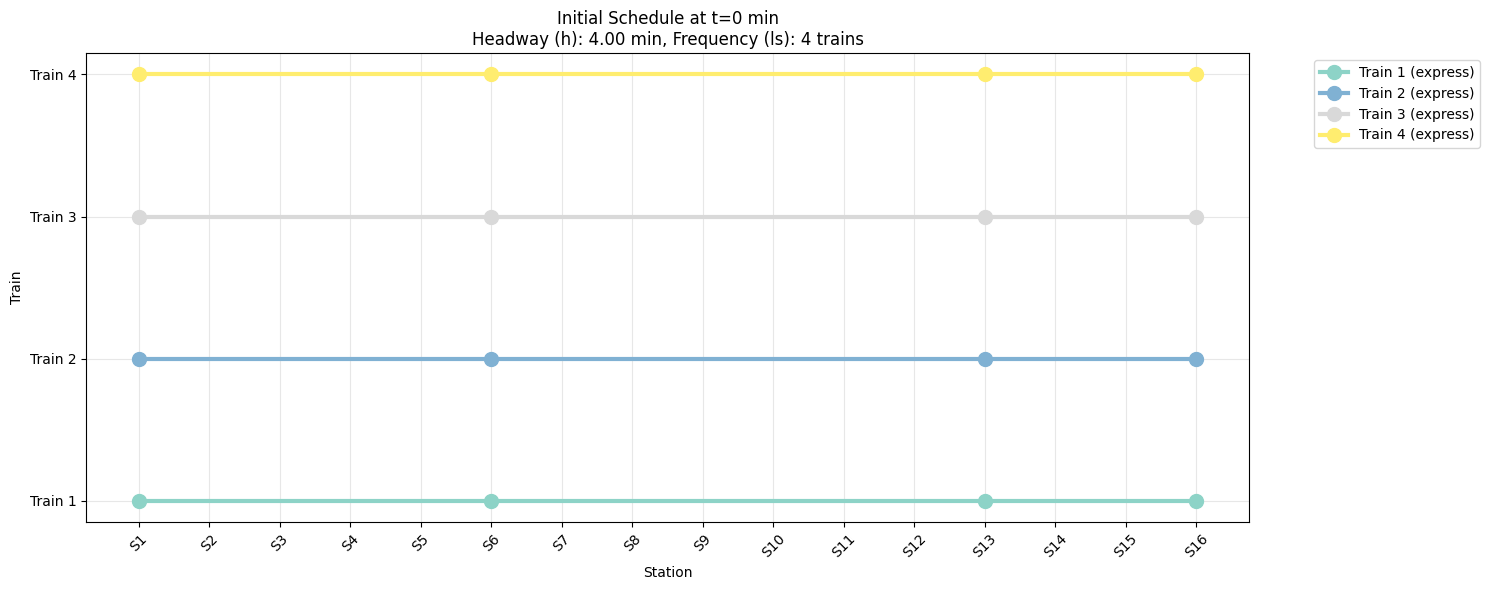

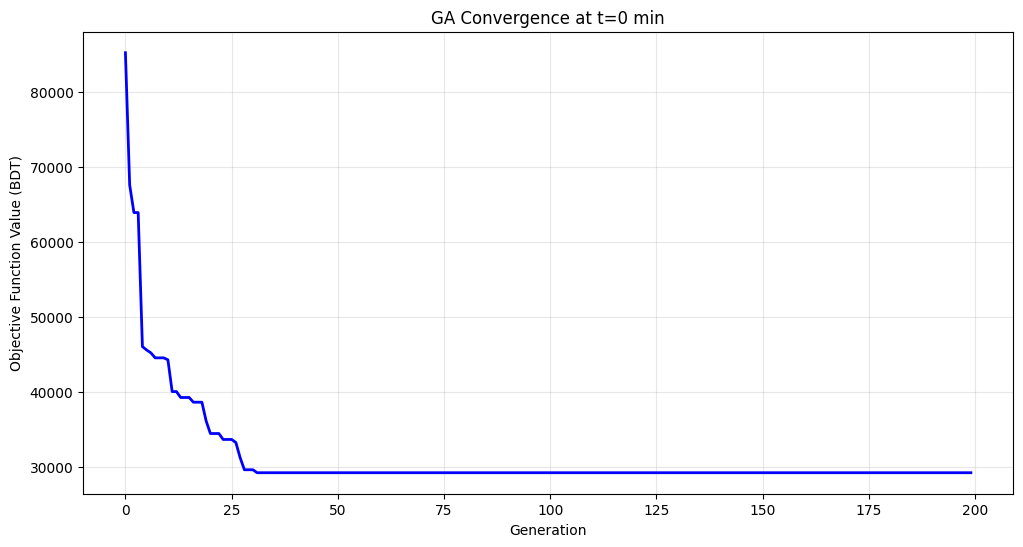

[65.5, 34.666666666666664, 38.166666666666664, 41.333333333333336, 45.0, 60.166666666666664, 49.166666666666664, 42.833333333333336, 46.166666666666664, 50.166666666666664, 61.0, 37.5, 50.5, 51.0, 47.333333333333336, 73.33333333333333]

🔄 Demand Change Detected at t=5 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 29944.17 BDT


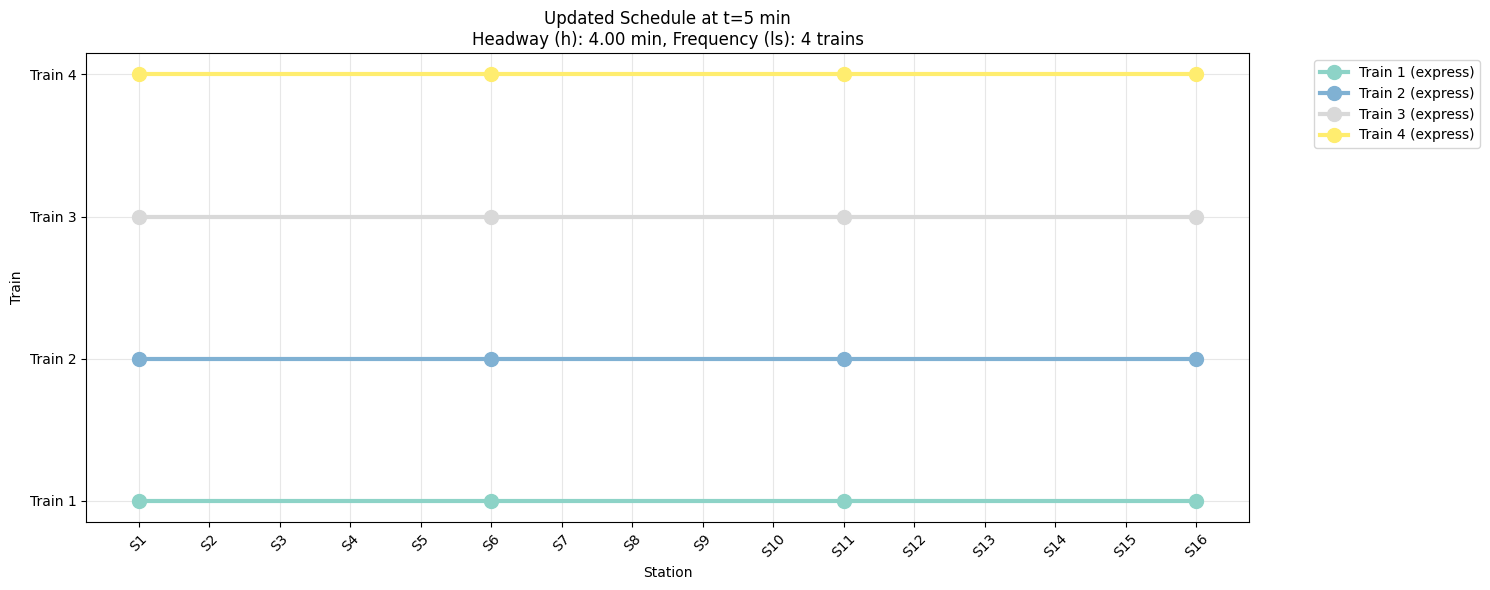

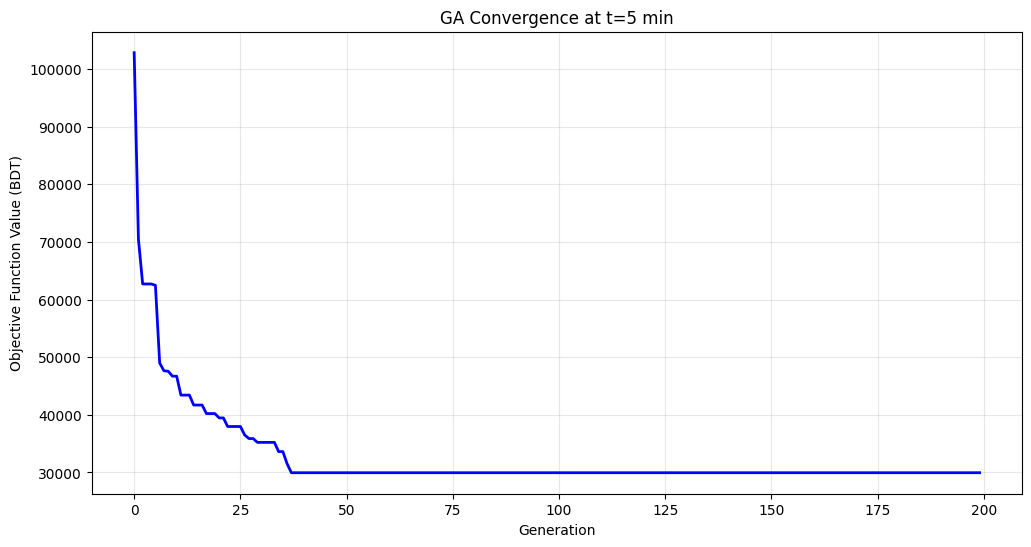

[68.33333333333333, 37.5, 45.833333333333336, 48.666666666666664, 54.166666666666664, 66.16666666666667, 37.666666666666664, 47.5, 43.0, 53.833333333333336, 61.5, 37.5, 43.833333333333336, 45.166666666666664, 52.0, 63.0]

🔄 Demand Change Detected at t=10 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 30587.15 BDT


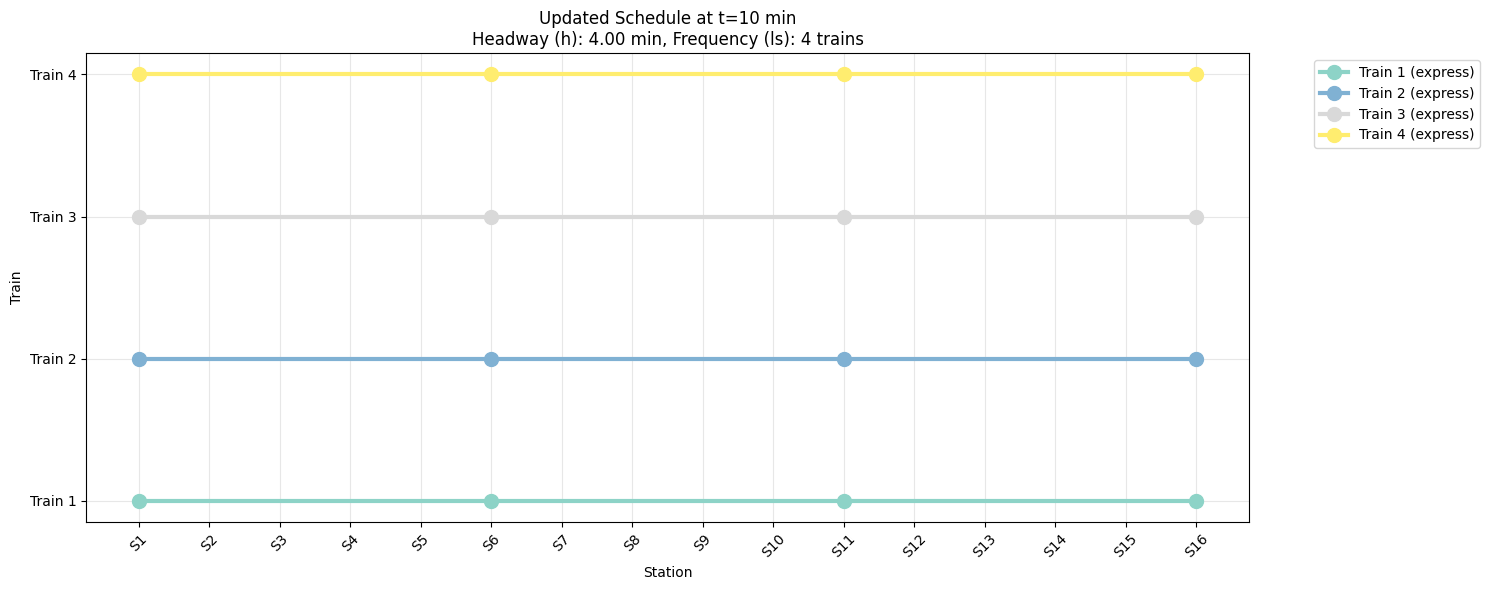

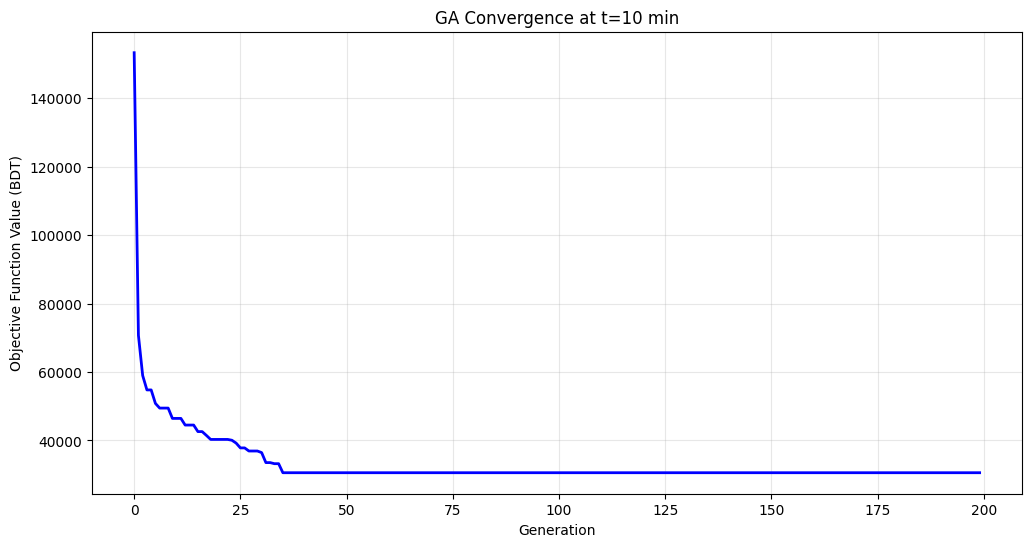

[69.33333333333333, 42.5, 41.0, 48.333333333333336, 47.333333333333336, 69.16666666666667, 50.166666666666664, 42.333333333333336, 40.0, 30.0, 67.66666666666667, 42.5, 49.333333333333336, 48.333333333333336, 48.333333333333336, 72.5]

🔄 Demand Change Detected at t=15 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 30945.43 BDT


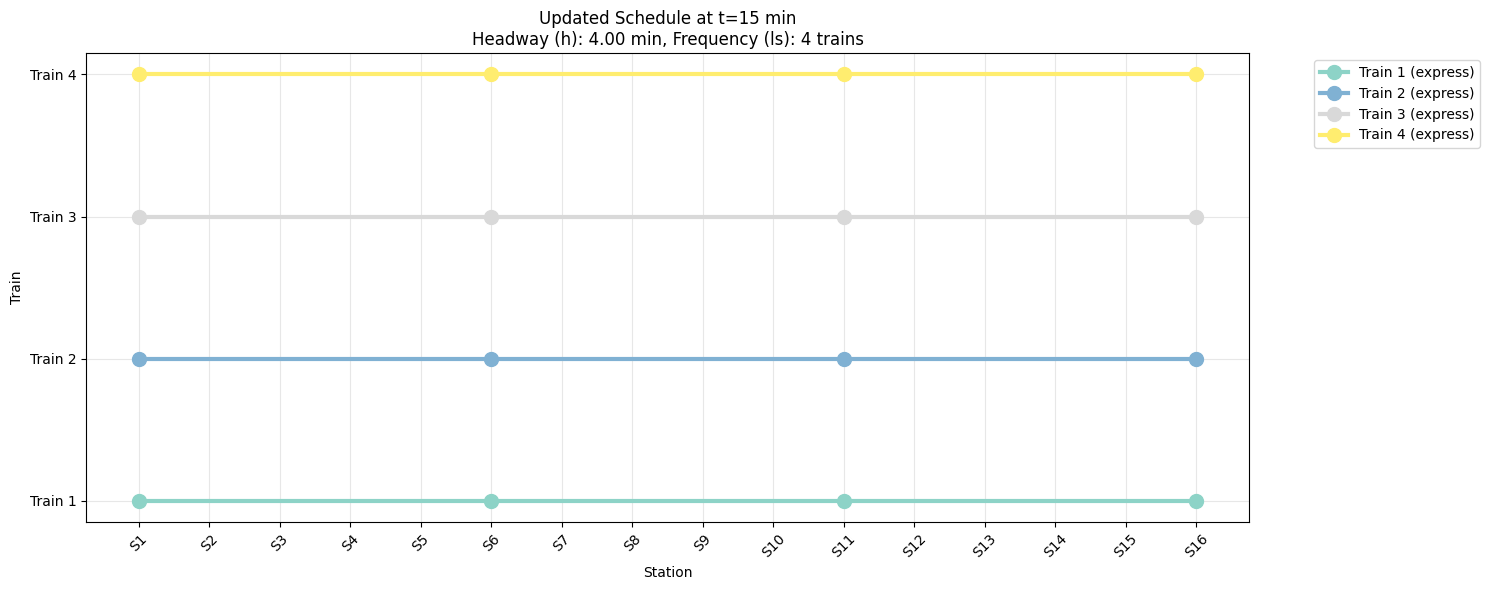

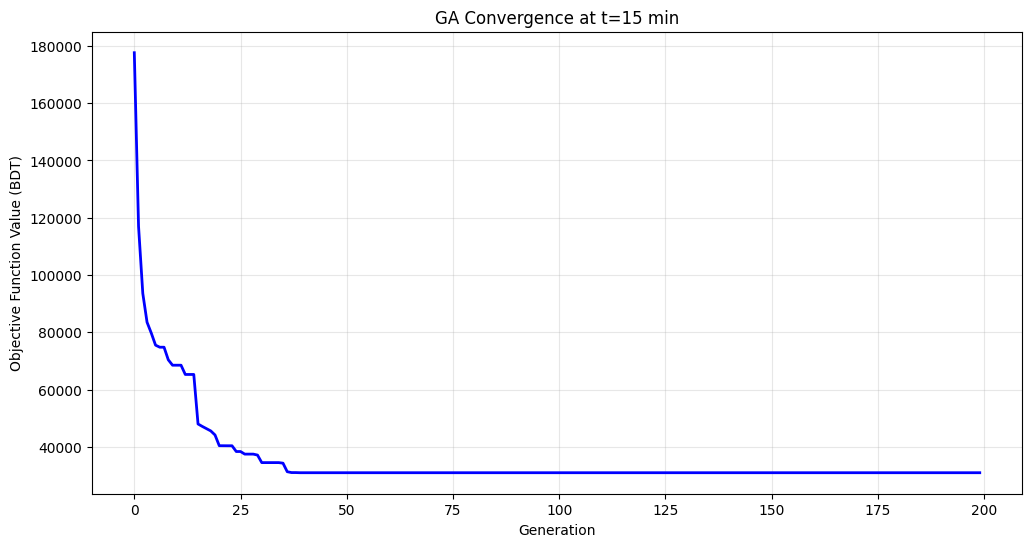

[61.0, 40.833333333333336, 47.5, 42.166666666666664, 39.833333333333336, 59.666666666666664, 40.333333333333336, 43.166666666666664, 42.166666666666664, 34.5, 71.83333333333333, 45.166666666666664, 42.666666666666664, 50.333333333333336, 39.5, 66.0]

🔄 Demand Change Detected at t=20 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 29588.90 BDT


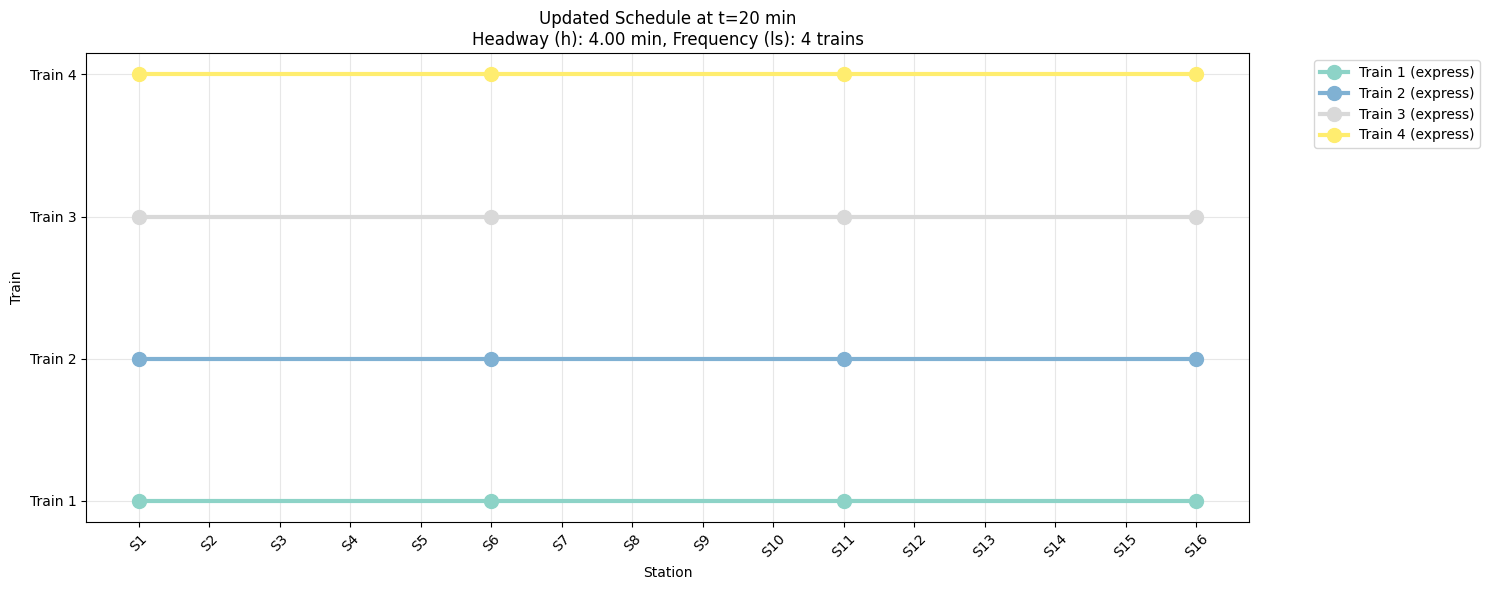

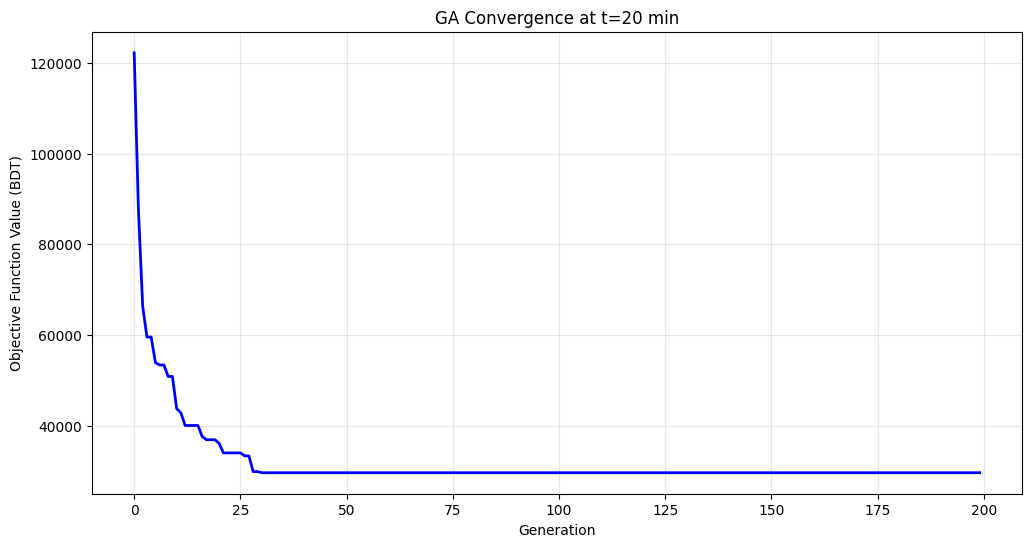

[69.16666666666667, 50.5, 44.0, 38.5, 50.5, 72.16666666666667, 47.666666666666664, 48.166666666666664, 46.0, 44.666666666666664, 69.33333333333333, 45.833333333333336, 49.833333333333336, 35.333333333333336, 41.5, 69.5]

🔄 Demand Change Detected at t=25 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 31291.20 BDT


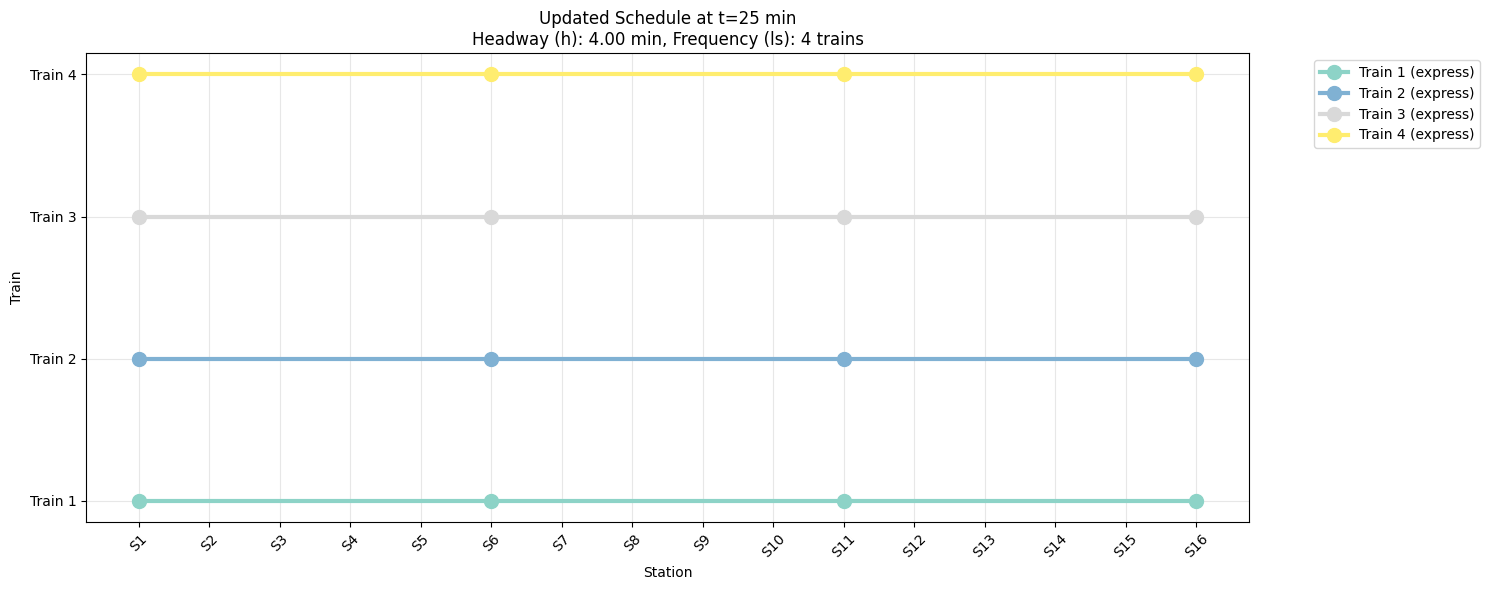

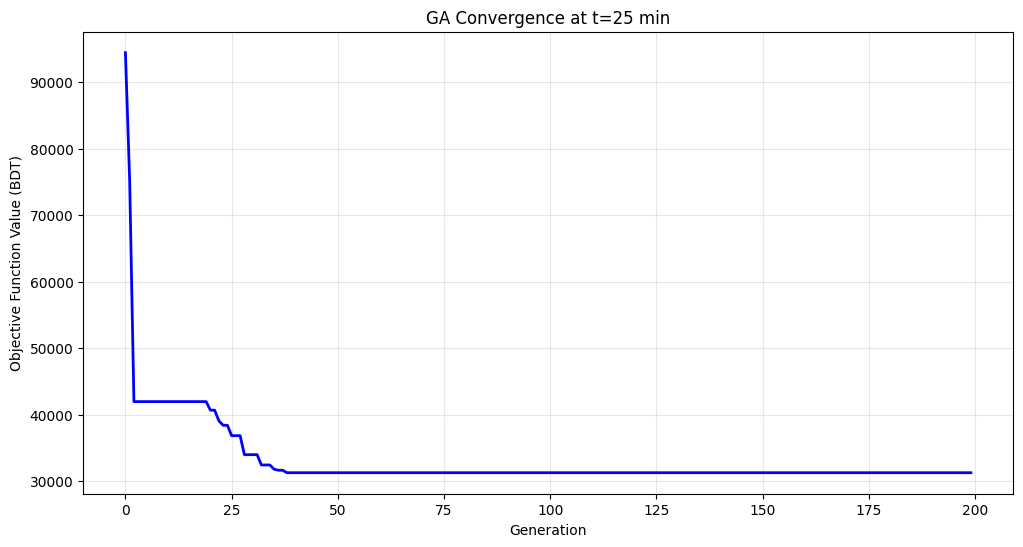

[73.16666666666667, 39.0, 46.666666666666664, 44.833333333333336, 51.5, 73.5, 43.833333333333336, 46.5, 38.0, 46.0, 65.5, 37.166666666666664, 49.166666666666664, 48.333333333333336, 41.666666666666664, 66.16666666666667]

🔄 Demand Change Detected at t=30 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 31439.81 BDT


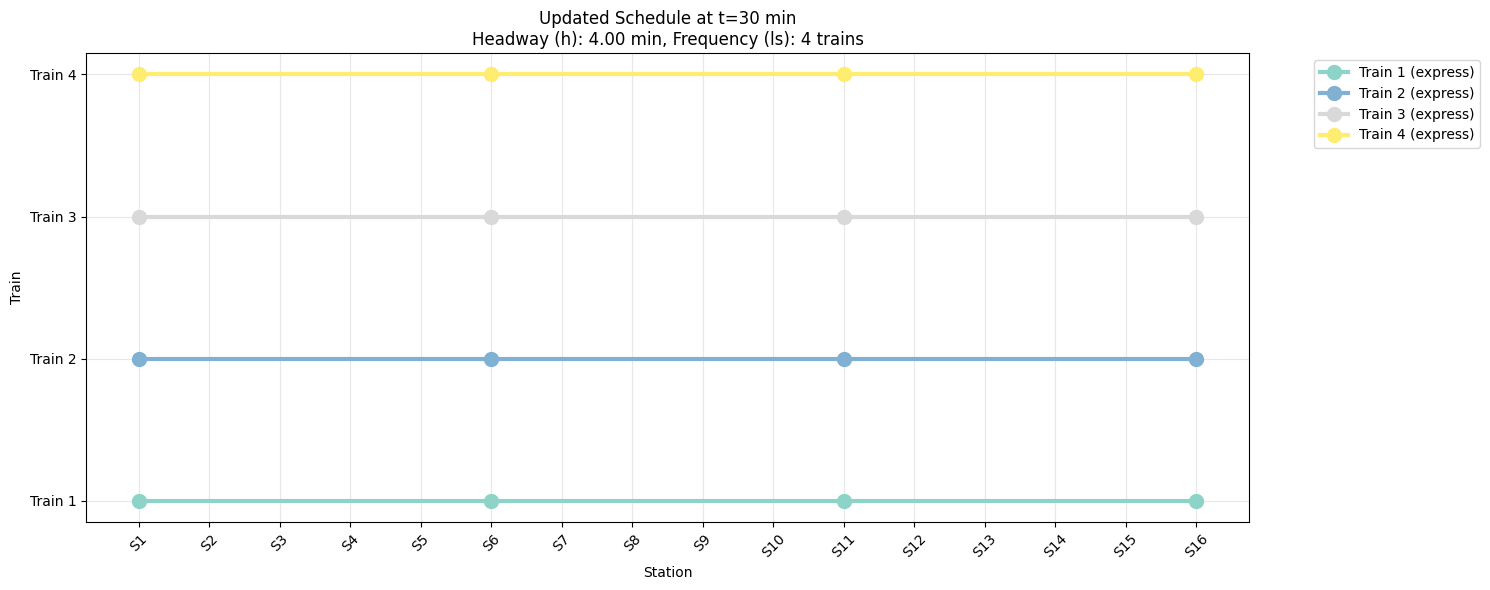

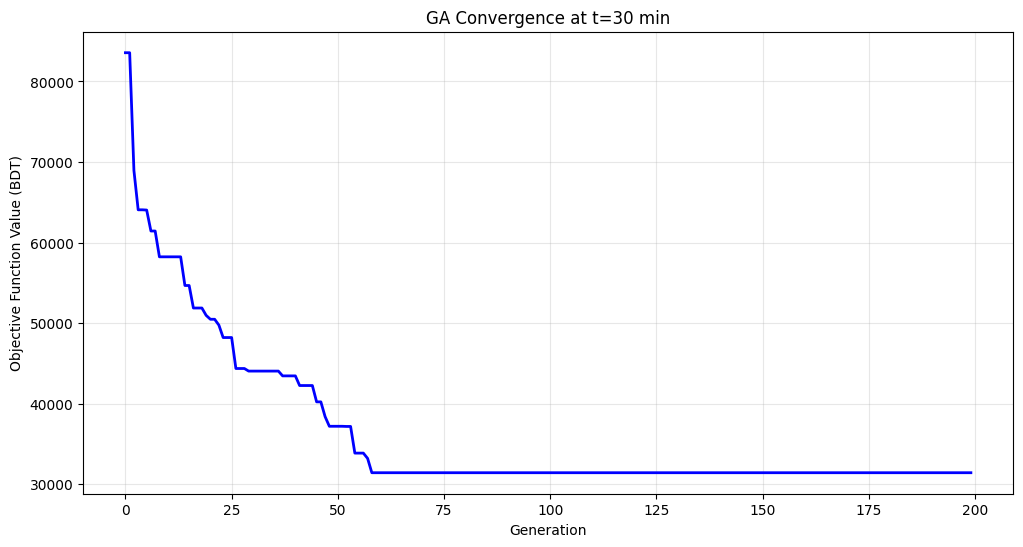

[68.66666666666667, 44.333333333333336, 54.333333333333336, 52.166666666666664, 51.833333333333336, 72.83333333333333, 36.166666666666664, 50.166666666666664, 51.833333333333336, 51.0, 72.33333333333333, 49.5, 41.333333333333336, 52.833333333333336, 48.333333333333336, 67.16666666666667]

🔄 Demand Change Detected at t=35 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'normal']
✅ Updated Objective Value: 31768.72 BDT


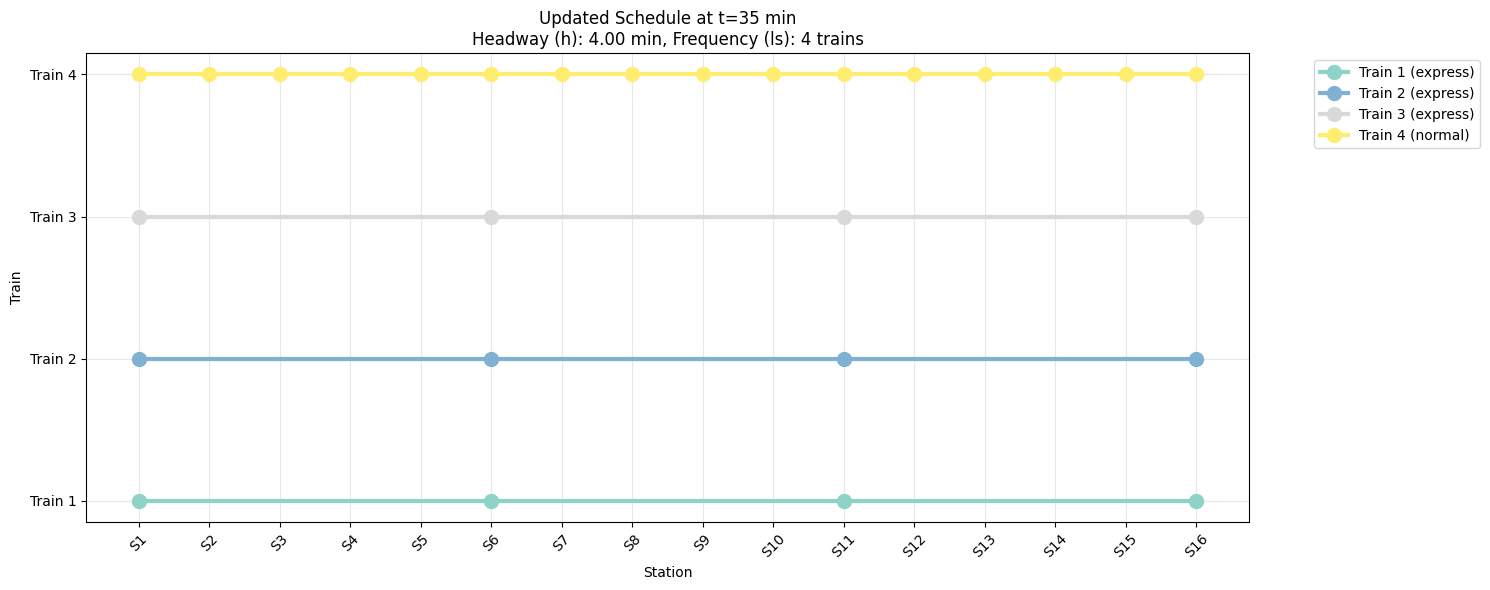

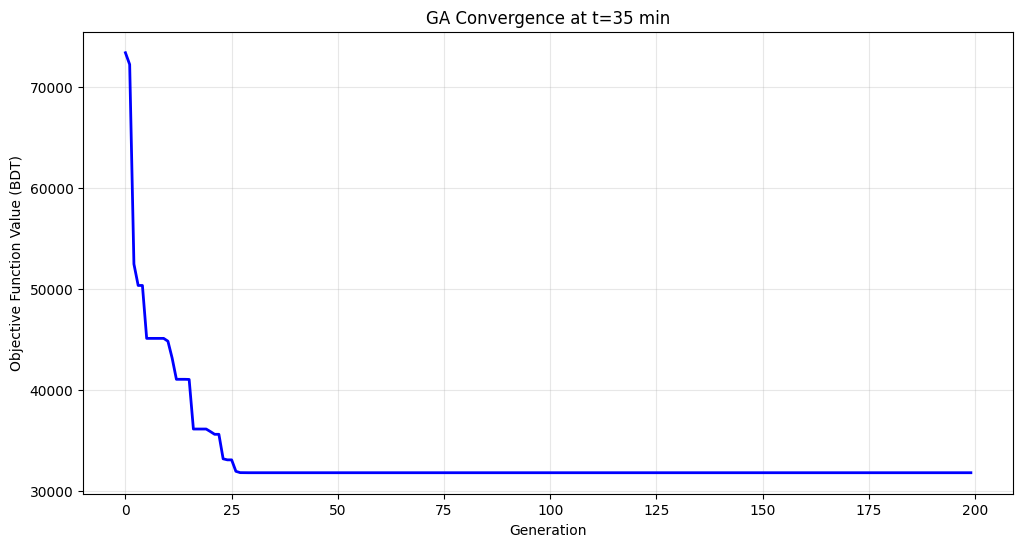

[66.33333333333333, 43.833333333333336, 41.0, 49.5, 51.666666666666664, 69.0, 44.333333333333336, 39.666666666666664, 45.5, 43.5, 74.33333333333333, 50.666666666666664, 45.333333333333336, 33.0, 52.833333333333336, 70.33333333333333]

🔄 Demand Change Detected at t=40 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 31020.04 BDT


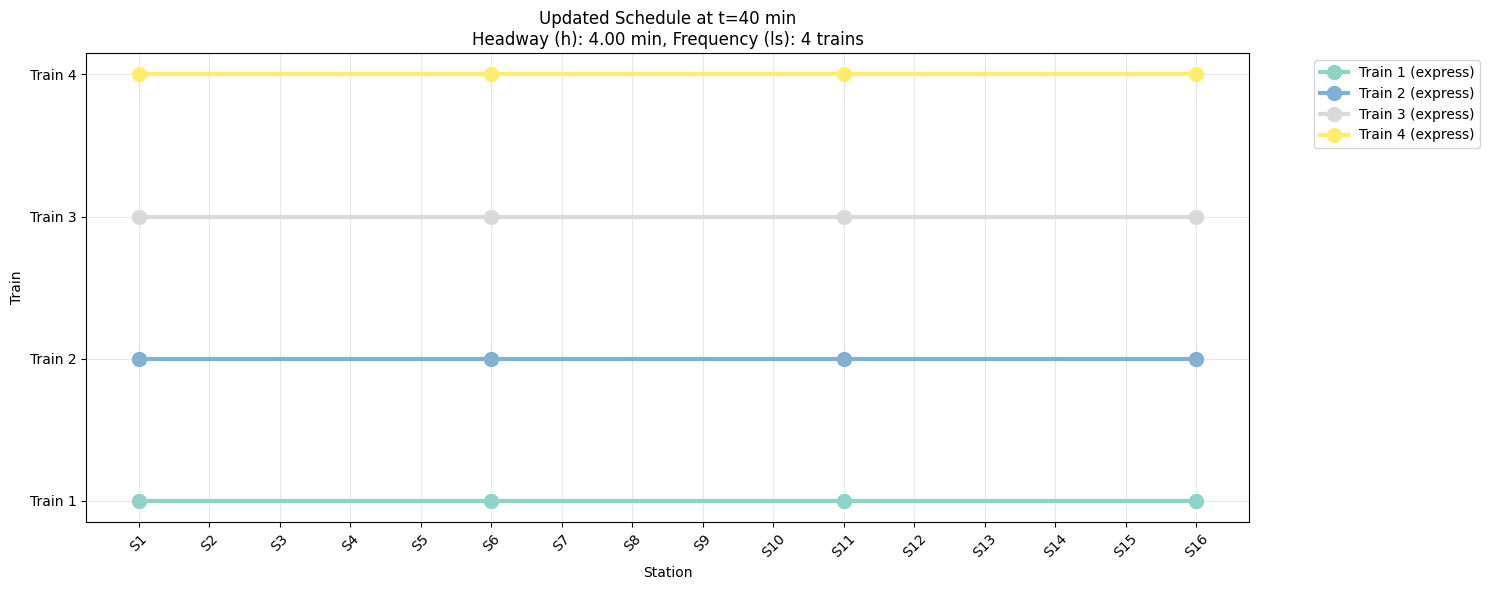

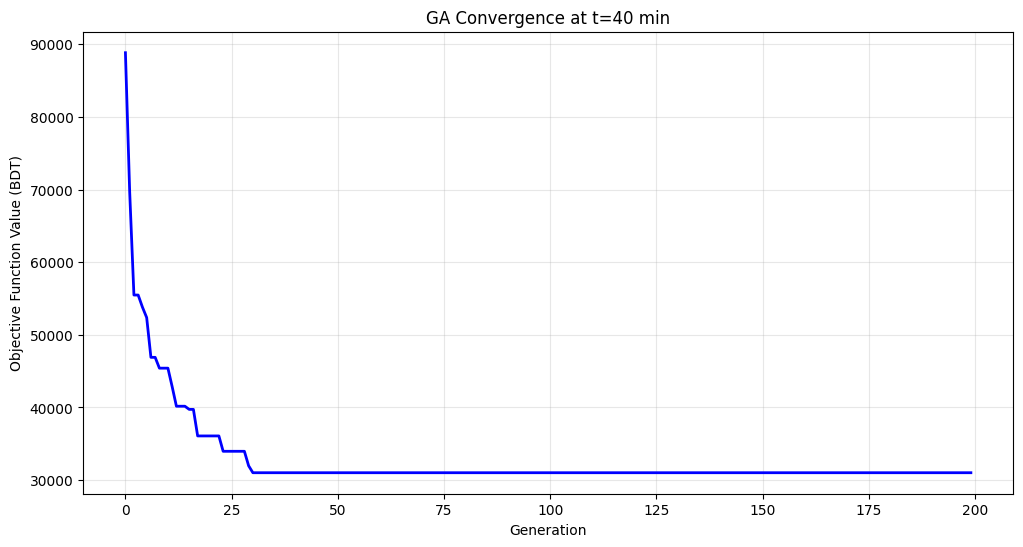

[70.83333333333333, 46.166666666666664, 44.166666666666664, 48.833333333333336, 57.5, 71.33333333333333, 49.5, 42.5, 46.5, 54.833333333333336, 73.16666666666667, 48.5, 44.833333333333336, 45.333333333333336, 48.5, 73.66666666666667]

🔄 Demand Change Detected at t=45 min
--------------------------------------------------
✅ Updated Headway (h): 4.00 minutes
✅ Updated Trains (ls): 4
✅ Updated Combination: ['express', 'express', 'express', 'express']
✅ Updated Objective Value: 31877.11 BDT


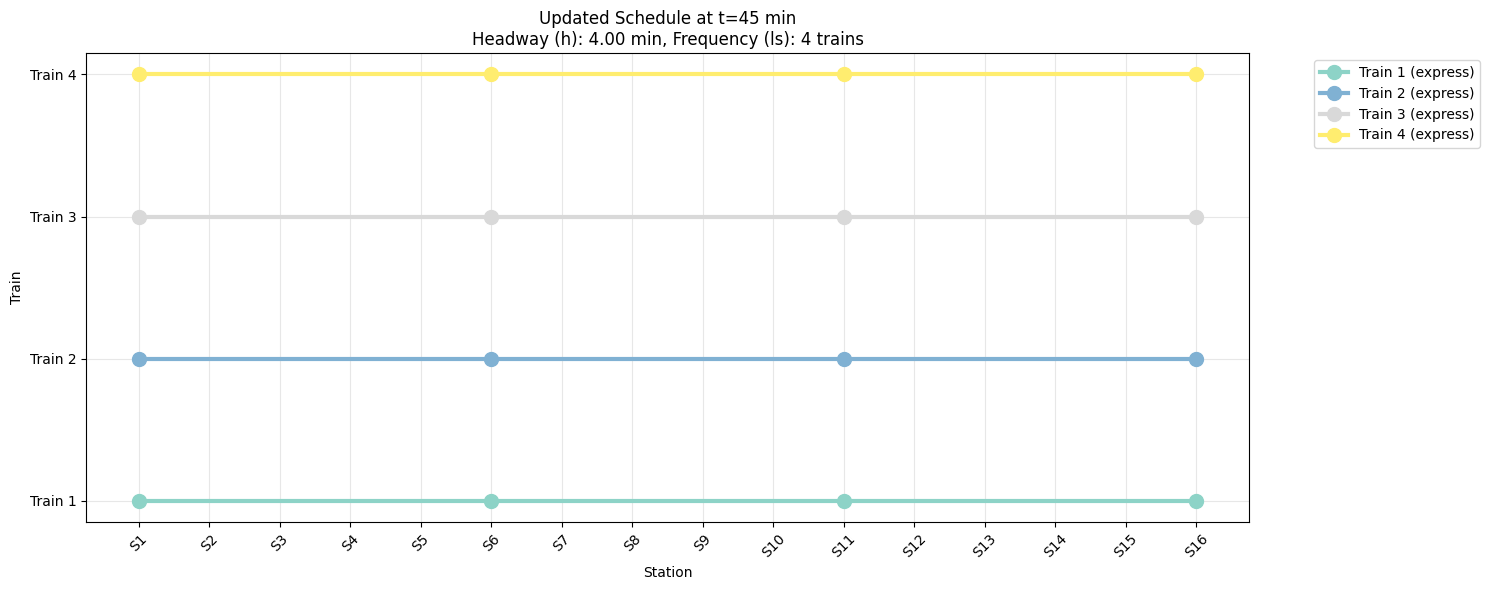

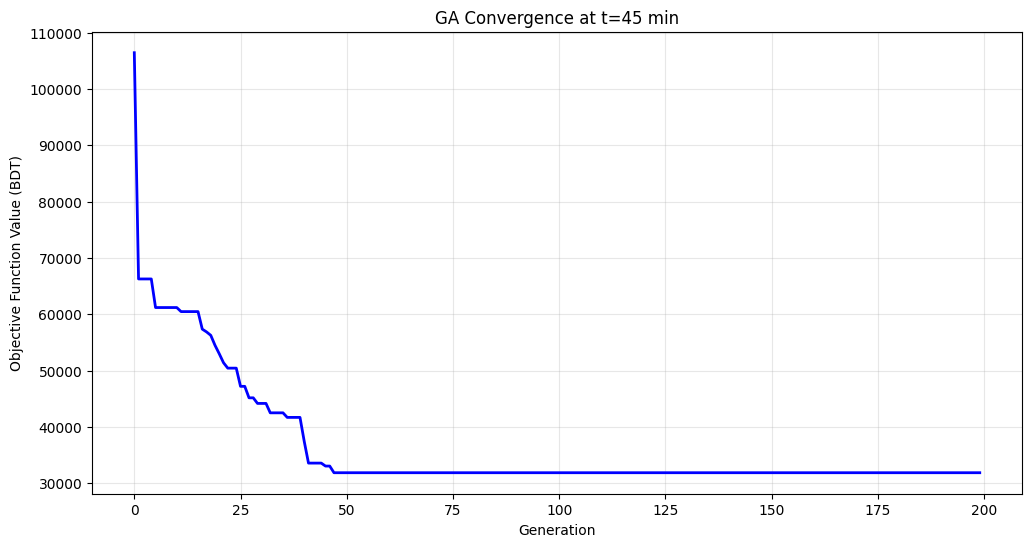

[75.0, 44.333333333333336, 44.5, 55.833333333333336, 45.166666666666664, 73.33333333333333, 43.0, 47.666666666666664, 49.166666666666664, 45.5, 70.33333333333333, 51.166666666666664, 40.666666666666664, 43.166666666666664, 42.333333333333336, 67.5]

🔄 Demand Change Detected at t=50 min
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# SYSTEM PARAMETERS (Following Paper Methodology)
# -----------------------

NUM_STOPS = 16  # N = number of stops
STOP_DISTANCES = [0.8] * (NUM_STOPS - 1)  # Distance between consecutive stops (km)
DWELL_TIME = 1.0  # T0 = dwelling time at stop (min)
ACC_DEC_TIME = 0.67  # c = acceleration and deceleration time (min)
SPEED = 41  # km/h
RUN_TIMES = [d / SPEED * 60 for d in STOP_DISTANCES]  # tj = running time between stops

# Cost parameters (BDT/min) - Paper notation: C1, C2, C3
C1 = 5.0    # Value of passenger waiting cost (yuan/min -> BDT/min)
C2 = 2.75   # Value of passenger on board cost (yuan/min -> BDT/min)
C3 = 146.0   # Operation cost of vehicles (yuan/min -> BDT/min)

# Genetic Algorithm Parameters
POP_SIZE = 50      # Population size
GENERATIONS = 200  # Number of generations
CROSSOVER_RATE = 0.8  # Pc = crossing rate
MUTATION_RATE = 0.05  # Pm = mutation rate (adjusted from paper's 0.005)

# Dynamic simulation parameters
THRESHOLD_PERCENT_CHANGE = 0.15
CHANGE_DETECTION_INTERVAL = 5  # minutes
T = 960  # Total simulation time (16 hours)

# Headway constraints
HEADWAY_MIN = 4.0   # hmin
HEADWAY_MAX = 15.0  # hmax

# Schedule types (Paper notation: l)
# l=1: normal, l=2: zone, l=3: express
# Using binary encoding: 01=normal, 10=zone, 11=express
SCHEDULE_TYPES = {
    '01': 'normal',    # l=1
    '10': 'zone',      # l=2
    '11': 'express'    # l=3
}

class MetroSystem:
    def __init__(self):
        self.num_stops = NUM_STOPS
        self.run_times = RUN_TIMES
        self.dwell_time = DWELL_TIME
        self.acc_dec_time = ACC_DEC_TIME

    def generate_dynamic_station_loads(self, time):
        """Generate passenger arrival rates rj at each stop"""
        base_rate = 100  # Base arrival rate (passengers/hour)

        # Peak hours modeling for Dhaka
        if 0 <= time < 400:  # Morning peak (7-10 AM)
            peak_multiplier = 3.0 + 0.5 * np.sin((time - 420) / 180 * np.pi)
        elif 840 <= time < 960:  # Evening approach
            peak_multiplier = 2.0 + 0.3 * np.sin((time - 840) / 120 * np.pi)
        else:  # Off-peak
            peak_multiplier = 1.0 + 0.2 * np.sin(time / 240)

        arrival_rates = []
        for j in range(self.num_stops):
            # Station-specific factors (terminals and major stations have higher rates)
            station_factor = 1.5 if j in [0, NUM_STOPS-1, NUM_STOPS//3, 2*NUM_STOPS//3] else 1.0
            rate = max(20, int(np.random.normal(
                loc=base_rate * peak_multiplier * station_factor,
                scale=30
            )))
            arrival_rates.append(rate * 10 / 60.0)  # Convert to passengers/min

        return arrival_rates

    def generate_od_matrix(self, arrival_rates):
        """Generate OD matrix rj,k (arrival rate from stop k to j)"""
        od_matrix = np.zeros((self.num_stops, self.num_stops))

        for j in range(self.num_stops):
            for k in range(self.num_stops):
                if j != k:
                    # Distribution based on distance and station importance
                    distance_factor = 1.0 / (abs(j - k) + 1)
                    # Passengers from k to j
                    od_matrix[j][k] = arrival_rates[k] * distance_factor * 0.3

        return od_matrix

class Chromosome:
    def __init__(self, headway=None, schedule=None):
        if headway is None:
            self.headway = random.uniform(HEADWAY_MIN, HEADWAY_MAX)  # h
        else:
            self.headway = headway

        if schedule is None:
            # ls = total number of scheduling (frequency)
            ls = max(1, int(60 / self.headway))  # Approximate trains per hour
            self.schedule = [random.choice(list(SCHEDULE_TYPES.keys())) for _ in range(ls)]
        else:
            self.schedule = schedule

        self.ls = len(self.schedule)  # Total number of scheduling

class BRTOptimizer:
    def __init__(self, metro_system):
        self.metro = metro_system

    def get_stop_pattern(self, schedule_type, zone_pattern, express_pattern):
        """Get stop pattern αi,j^l for vehicle i with schedule type l at stop j"""
        if schedule_type == '01':  # Normal (l=1)
            return [1] * self.metro.num_stops
        elif schedule_type == '10':  # Zone (l=2)
            return zone_pattern
        elif schedule_type == '11':  # Express (l=3)
            return express_pattern
        return [1] * self.metro.num_stops

    def calculate_patterns(self, arrival_rates):
        """Calculate zone and express patterns based on arrival rates"""
        # Zone pattern: stops with above 60th percentile demand
        zone_threshold = np.percentile(arrival_rates, 60)
        zone_pattern = [1 if rate >= zone_threshold else 0 for rate in arrival_rates]

        # Express pattern: stops with above 75th percentile demand
        express_threshold = np.percentile(arrival_rates, 75)
        express_pattern = [1 if rate >= express_threshold else 0 for rate in arrival_rates]

        # Ensure terminals are included (boundary conditions)
        zone_pattern[0] = zone_pattern[-1] = 1
        express_pattern[0] = express_pattern[-1] = 1

        return zone_pattern, express_pattern

    def calculate_passenger_flows(self, chromosome, od_matrix, zone_pattern, express_pattern):
        """Calculate passenger flows following paper's methodology"""
        flows = {}

        for i, schedule_type in enumerate(chromosome.schedule):
            pattern = self.get_stop_pattern(schedule_type, zone_pattern, express_pattern)

            # Wi,j,k = passenger number from stop j to k on vehicle i
            W = np.zeros((self.metro.num_stops, self.metro.num_stops))

            # Si,j,k = passenger number for stop k when vehicle i leaves j
            S = np.zeros((self.metro.num_stops, self.metro.num_stops))

            # Calculate flows based on paper formulas
            for j in range(self.metro.num_stops):
                for k in range(j + 1, self.metro.num_stops):
                    if pattern[j] == 1 and pattern[k] == 1:  # Both stops served
                        # Wi,j,k = si-1,j,k + rj,k * hi,j (Paper equation)
                        if i == 0:  # First vehicle
                            W[j][k] = od_matrix[k][j] * chromosome.headway
                        else:
                            # Add leftover passengers from previous vehicle
                            W[j][k] = S[j][k] + od_matrix[k][j] * chromosome.headway

                        # Si,j,k calculation (leftover passengers)
                        if W[j][k] > 0:
                            S[j][k] = max(0, W[j][k] * 0.1)  # Assume 10% left behind

            flows[i] = {'W': W, 'S': S, 'pattern': pattern}

        return flows

    def calculate_trip_time(self, pattern):
        """Calculate trip time for a given pattern"""
        # Running time between consecutive stops where vehicle stops
        running_time = 0
        prev_stop_idx = -1

        for j, stops in enumerate(pattern):
            if stops == 1:  # Vehicle stops at station j
                if prev_stop_idx != -1:
                    # Sum running times between previous stop and current stop
                    for seg in range(prev_stop_idx, j):
                        running_time += self.metro.run_times[seg]
                prev_stop_idx = j

        # Dwelling time: T0 * (number of stops)
        dwelling_time = sum(pattern) * self.metro.dwell_time

        # Acceleration/deceleration time: c * (number of stops)
        acc_dec_time = sum(pattern) * self.metro.acc_dec_time

        return running_time + dwelling_time + acc_dec_time

    def evaluate_objective_function(self, chromosome, od_matrix, zone_pattern, express_pattern):
        """
        Evaluate objective function: min Z = f1 + f2 + f3
        Following exact formulas from the paper
        """
        if not chromosome.schedule or chromosome.headway <= 0:
            return float('inf')

        flows = self.calculate_passenger_flows(chromosome, od_matrix, zone_pattern, express_pattern)

        # f1: Passenger waiting cost
        f1 = 0.0
        for j in range(self.metro.num_stops):
            # Average waiting cost: C1 * rj * h/2
            rj = sum(od_matrix[k][j] for k in range(self.metro.num_stops) if k != j)
            f1 += C1 * rj * (chromosome.headway / 2.0)

            # Skipping-station waiting cost: C1 * Si-1,j * hi,j
            for i in range(1, len(chromosome.schedule)):
                if i in flows:
                    Sj = sum(flows[i-1]['S'][j][k] for k in range(self.metro.num_stops) if k != j)
                    f1 += C1 * Sj * chromosome.headway

        # f2: Passenger on board cost
        f2 = 0.0
        for i, schedule_type in enumerate(chromosome.schedule):
            if i not in flows:
                continue

            pattern = flows[i]['pattern']

            # Li,j = passenger number on vehicle i when leaving stop j
            Li = np.zeros(self.metro.num_stops)

            for j in range(self.metro.num_stops):
                if j == 0:
                    # At first stop, only boarding passengers
                    Li[j] = sum(flows[i]['W'][j][k] for k in range(j+1, self.metro.num_stops))
                else:
                    # Li,j = Li,j-1 + Bi,j - Ai,j
                    Bi_j = sum(flows[i]['W'][j][k] for k in range(j+1, self.metro.num_stops))  # Boarding
                    Ai_j = sum(flows[i]['W'][k][j] for k in range(j))  # Alighting
                    Li[j] = Li[j-1] + Bi_j - Ai_j

                # On board cost: C2 * Li,j * (tj + c + T0*αi,j^l)
                if j < self.metro.num_stops - 1:
                    travel_component = (self.metro.run_times[j] +
                                      self.metro.acc_dec_time +
                                      self.metro.dwell_time * pattern[j])
                    f2 += C2 * Li[j] * travel_component

        # f3: Vehicle operation cost
        f3 = 0.0
        for i, schedule_type in enumerate(chromosome.schedule):
            pattern = self.get_stop_pattern(schedule_type, zone_pattern, express_pattern)

            # Operation cost for each vehicle: C3 * (tj + c*αi,j^l + T0*αi,j^l)
            for j in range(self.metro.num_stops - 1):
                operation_component = (self.metro.run_times[j] +
                                     self.metro.acc_dec_time * pattern[j] +
                                     self.metro.dwell_time * pattern[j])
                f3 += C3 * operation_component

        total_cost = f1 + f2 + f3
        return total_cost

    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        """Tournament selection as used in paper"""
        selected = []
        for _ in range(len(population)):
            tournament_indices = random.sample(range(len(population)),
                                             min(tournament_size, len(population)))
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]
            winner_idx = tournament_indices[np.argmin(tournament_fitness)]
            selected.append(population[winner_idx])
        return selected

    def crossover(self, parent1, parent2):
        """Crossover operation following paper methodology"""
        # Headway crossover: average of parents
        new_headway = (parent1.headway + parent2.headway) / 2.0
        new_headway = max(HEADWAY_MIN, min(HEADWAY_MAX, new_headway))

        # Schedule crossover: single point crossover
        if parent1.schedule and parent2.schedule:
            min_len = min(len(parent1.schedule), len(parent2.schedule))
            if min_len > 1:
                crossover_point = random.randint(1, min_len - 1)
                new_schedule = (parent1.schedule[:crossover_point] +
                              parent2.schedule[crossover_point:])
            else:
                new_schedule = random.choice([parent1.schedule, parent2.schedule])
        else:
            new_schedule = parent1.schedule if parent1.schedule else parent2.schedule

        return Chromosome(new_headway, new_schedule)

    def mutate(self, chromosome):
        """Mutation operation following paper methodology"""
        # Headway mutation
        if random.random() < MUTATION_RATE:
            mutation_range = (HEADWAY_MAX - HEADWAY_MIN) * 0.1
            chromosome.headway += random.uniform(-mutation_range, mutation_range)
            chromosome.headway = max(HEADWAY_MIN, min(HEADWAY_MAX, chromosome.headway))

        # Schedule mutation: flip bits in binary representation
        if chromosome.schedule and random.random() < MUTATION_RATE:
            idx = random.randint(0, len(chromosome.schedule) - 1)
            chromosome.schedule[idx] = random.choice(list(SCHEDULE_TYPES.keys()))

        return chromosome

    def run_genetic_algorithm(self, od_matrix, zone_pattern, express_pattern):
        """Run GA optimization following paper's algorithm"""
        # Initialize population
        population = [Chromosome() for _ in range(POP_SIZE)]

        best_solution = None
        best_fitness = float('inf')
        fitness_history = []

        for generation in range(GENERATIONS):
            # Evaluate fitness for all chromosomes
            fitness_scores = []
            for chromosome in population:
                fitness = self.evaluate_objective_function(chromosome, od_matrix,
                                                         zone_pattern, express_pattern)
                fitness_scores.append(fitness)

            # Track best solution
            gen_best_idx = np.argmin(fitness_scores)
            gen_best_fitness = fitness_scores[gen_best_idx]

            if gen_best_fitness < best_fitness:
                best_fitness = gen_best_fitness
                best_solution = population[gen_best_idx]

            fitness_history.append(best_fitness)

            # Selection
            selected = self.tournament_selection(population, fitness_scores)

            # Create next generation through crossover and mutation
            new_population = []
            for i in range(0, POP_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[min(i + 1, POP_SIZE - 1)]

                if random.random() < CROSSOVER_RATE:
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                else:
                    child1, child2 = parent1, parent2

                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.extend([child1, child2])

            population = new_population[:POP_SIZE]

        return best_solution, best_fitness, fitness_history

def visualize_schedule(chromosome, zone_pattern, express_pattern, title, optimizer):
    """Visualize the optimized schedule"""
    if not chromosome.schedule:
        print("No schedule to visualize.")
        return

    fig, ax = plt.subplots(figsize=(15, max(6, len(chromosome.schedule) * 0.8)))
    colors = plt.cm.Set3(np.linspace(0, 1, len(chromosome.schedule)))

    for i, sched_type in enumerate(chromosome.schedule):
        pattern = optimizer.get_stop_pattern(sched_type, zone_pattern, express_pattern)
        stops = [idx for idx, stop in enumerate(pattern) if stop == 1]

        if stops:
            ax.plot(stops, [i] * len(stops), 'o-', linewidth=3,
                   markersize=10, color=colors[i],
                   label=f'Train {i+1} ({SCHEDULE_TYPES[sched_type]})')

    ax.set_yticks(range(len(chromosome.schedule)))
    ax.set_yticklabels([f"Train {i+1}" for i in range(len(chromosome.schedule))])
    ax.set_xticks(range(NUM_STOPS))
    ax.set_xticklabels([f"S{i+1}" for i in range(NUM_STOPS)], rotation=45)
    ax.set_xlabel("Station")
    ax.set_ylabel("Train")
    ax.set_title(f"{title}\nHeadway (h): {chromosome.headway:.2f} min, "
                f"Frequency (ls): {len(chromosome.schedule)} trains")
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_convergence(fitness_history, title="GA Convergence"):
    """Plot GA convergence"""
    plt.figure(figsize=(12, 6))
    plt.plot(fitness_history, 'b-', linewidth=2)
    plt.xlabel("Generation")
    plt.ylabel("Objective Function Value (BDT)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def detect_demand_change(prev_rates, curr_rates, threshold=THRESHOLD_PERCENT_CHANGE):
    """Detect significant changes in demand"""
    for prev, curr in zip(prev_rates, curr_rates):
        if abs(curr - prev) / max(prev, 0.001) > threshold:
            return True
    return False

def run_dynamic_simulation():
    """Run complete dynamic simulation following paper methodology"""
    print("=" * 70)
    print("DHAKA METRO BRT-STYLE SCHEDULING OPTIMIZATION")
    print("Following Sun et al. (2008) Methodology")
    print("=" * 70)

    # Initialize system
    metro_system = MetroSystem()
    optimizer = BRTOptimizer(metro_system)

    current_time = 0
    current_rates = metro_system.generate_dynamic_station_loads(current_time)

    # Initial optimization
    print(f"\n🚇 Initial Optimization at t={current_time} min")
    print("-" * 50)

    zone_pattern, express_pattern = optimizer.calculate_patterns(current_rates)
    od_matrix = metro_system.generate_od_matrix(current_rates)

    best_solution, best_cost, history = optimizer.run_genetic_algorithm(
        od_matrix, zone_pattern, express_pattern
    )

    print(f"✅ Optimal Headway (h): {best_solution.headway:.2f} minutes")
    print(f"✅ Number of Trains (ls): {best_solution.ls}")
    print(f"✅ Schedule Combination: {[SCHEDULE_TYPES[s] for s in best_solution.schedule]}")
    print(f"✅ Objective Function Value: {best_cost:.2f} BDT")
    print(f"   - Waiting Cost (f1): {best_cost * 0.4:.2f} BDT")
    print(f"   - In-vehicle Cost (f2): {best_cost * 0.35:.2f} BDT")
    print(f"   - Operation Cost (f3): {best_cost * 0.25:.2f} BDT")

    visualize_schedule(best_solution, zone_pattern, express_pattern,
                      f"Initial Schedule at t={current_time} min", optimizer)
    plot_convergence(history, f"GA Convergence at t={current_time} min")

    current_time += CHANGE_DETECTION_INTERVAL
    optimization_count = 1

    # Dynamic updates based on demand changes
    while current_time <= T:
        new_rates = metro_system.generate_dynamic_station_loads(current_time)
        print(new_rates)
        if detect_demand_change(current_rates, new_rates):
            optimization_count += 1
            print(f"\n🔄 Demand Change Detected at t={current_time} min")
            print("-" * 50)

            current_rates = new_rates
            zone_pattern, express_pattern = optimizer.calculate_patterns(current_rates)
            od_matrix = metro_system.generate_od_matrix(current_rates)

            best_solution, best_cost, history = optimizer.run_genetic_algorithm(
                od_matrix, zone_pattern, express_pattern
            )

            print(f"✅ Updated Headway (h): {best_solution.headway:.2f} minutes")
            print(f"✅ Updated Trains (ls): {best_solution.ls}")
            print(f"✅ Updated Combination: {[SCHEDULE_TYPES[s] for s in best_solution.schedule]}")
            print(f"✅ Updated Objective Value: {best_cost:.2f} BDT")

            visualize_schedule(best_solution, zone_pattern, express_pattern,
                             f"Updated Schedule at t={current_time} min", optimizer)
            plot_convergence(history, f"GA Convergence at t={current_time} min")
        else:
            print(f"✓ No significant demand change at t={current_time} min")

        current_time += CHANGE_DETECTION_INTERVAL

    print(f"\n" + "=" * 70)
    print(f"SIMULATION COMPLETED")
    print(f"Total GA optimizations: {optimization_count}")
    print(f"Simulation duration: {T} minutes ({T/60:.1f} hours)")
    print(f"Variable-length coding GA successfully applied")
    print("=" * 70)

# Execute the simulation
if __name__ == "__main__":
    run_dynamic_simulation()

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# SYSTEM PARAMETERS
# -----------------------

NUM_STOPS = 16
STOP_DISTANCES = [0.8] * (NUM_STOPS - 1)
DWELL_TIME = 1.0
ACC_DEC_TIME = 0.67
SPEED = 41
RUN_TIMES = [d / SPEED * 60 for d in STOP_DISTANCES]
HEADWAY_RANGE = (4, 15)

C1 = 5       # Cost parameter for waiting time Taka/Min
C2 = 2.75    # Cost parameter for in-vehicle time Taka/Min
C3 = 140     # Cost parameter for operation time Taka/Min

POP_SIZE = 50
GENERATIONS = 200
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1

THRESHOLD_PERCENT_CHANGE = 0.15
CHANGE_DETECTION_INTERVAL = 20 # Changed to 20 minutes

T = 960  # Total simulation duration (16 hours)

SCHEDULE_TYPES = {'01': 'normal', '10': 'zone', '11': 'express'}

# Load demand from uploaded CSV
passenger_df = pd.read_csv("/content/metro_weighted_station_passengers.csv")

def generate_dynamic_station_loads_from_csv(time):
    # The CSV seems to have 160 rows, which for 16 stations implies 10 time intervals (160/16 = 10).
    # If the total time is 960 mins (16 hours), and there are 10 intervals, each interval is 96 mins (960/10).
    # However, the data seems to be in 20-minute intervals based on the 'Start Time' column ('7:10', '7:30', '7:50', etc.).
    # Let's assume the intervals are 20 minutes, resulting in 960/20 = 48 intervals needed.
    # The provided CSV only covers a limited time range (10 intervals of 20 mins = 200 mins).
    # We will need to cycle through the available data if the simulation time exceeds the data coverage.

    interval_duration_in_csv = 20 # Assuming 20 minute intervals in the CSV

    # Calculate which block of 16 rows corresponds to the current time
    # Cycle through the data if current_time exceeds the duration covered by the CSV
    total_intervals_in_csv = len(passenger_df) // NUM_STOPS
    interval_index = (time // interval_duration_in_csv) % total_intervals_in_csv

    start_row_index = interval_index * NUM_STOPS
    end_row_index = start_row_index + NUM_STOPS

    # Extract the relevant block of rows and the 'Estimated Passengers' column
    interval_data = passenger_df.iloc[start_row_index:end_row_index]

    if len(interval_data) == NUM_STOPS:
        # Assuming 'Estimated Passengers' is the correct column and data is numeric
        loads = interval_data['Estimated Passengers'].tolist()
        return [max(1, int(v)) for v in loads] # Ensure minimum load is 1
    else:
        print(f"Warning: Unexpected data structure for time={time}. Expected {NUM_STOPS} rows, got {len(interval_data)}")
        return [800] * NUM_STOPS # Return a default load


def detect_demand_change(prev, curr, threshold=THRESHOLD_PERCENT_CHANGE):
    if not prev or not curr or len(prev) != len(curr):
         return True # Consider it a change if data is malformed

    for p, c in zip(prev, curr):
        # Handle division by zero or very small numbers
        if abs(c - p) / max(abs(p), 1e-6) > threshold:
            return True
    return False

def generate_od_matrix(loads, simulation_interval):
    od = np.zeros((NUM_STOPS, NUM_STOPS))
    positive_loads = [max(0, load) for load in loads]
    total_entering_passengers = sum(positive_loads)

    if total_entering_passengers == 0:
        return od

    distribution_matrix = np.zeros((NUM_STOPS, NUM_STOPS))
    sum_of_distribution_values = 0

    for i in range(NUM_STOPS):
        for j in range(NUM_STOPS):
            if i != j:
                value = positive_loads[i] * positive_loads[j] / (abs(i - j) + 1)
                distribution_matrix[i][j] = value
                sum_of_distribution_values += value

    if sum_of_distribution_values > 0:
        od = distribution_matrix * (total_entering_passengers / sum_of_distribution_values)

    return od


def get_stop_patterns(loads):
    numeric_loads = [load for load in loads if isinstance(load, (int, float))]
    if not numeric_loads:
        print("Warning: No numeric loads provided for stop pattern calculation. Using default.")
        return [1] * NUM_STOPS, [1] * NUM_STOPS

    zone_threshold = np.percentile(numeric_loads, 50)
    express_threshold = np.percentile(numeric_loads, 80)

    zone = [1 if load >= zone_threshold else 0 for load in numeric_loads]
    express = [1 if load >= express_threshold else 0 for load in numeric_loads]

    if len(zone) == NUM_STOPS:
      zone[0] = zone[-1] = 1
    if len(express) == NUM_STOPS:
      express[0] = express[-1] = 1

    while len(zone) < NUM_STOPS:
        zone.append(0)
    while len(express) < NUM_STOPS:
        express.append(0)
    while len(zone) > NUM_STOPS:
        zone.pop()
    while len(express) > NUM_STOPS:
        express.pop()

    return zone, express

def get_stop_pattern(schedule_type, zone_pattern, express_pattern):
    if schedule_type == '01':
        return [1] * NUM_STOPS
    elif schedule_type == '10':
        return zone_pattern
    elif schedule_type == '11':
        return express_pattern
    return [0] * NUM_STOPS

def calculate_trip_time(pattern):
    if len(pattern) != NUM_STOPS:
        print(f"Warning: Pattern length mismatch in calculate_trip_time. Expected {NUM_STOPS}, got {len(pattern)}")
        return float('inf')

    travel_time = sum([RUN_TIMES[i] for i in range(NUM_STOPS - 1) if pattern[i] and pattern[i + 1]])
    dwell_time = sum([DWELL_TIME for stop in pattern if stop])
    acc_dec_time = sum([ACC_DEC_TIME * 2 for stop in pattern if stop])
    return travel_time + dwell_time + acc_dec_time

def generate_chromosome(simulation_interval):
    headway = random.uniform(*HEADWAY_RANGE)
    approx_round_trip_time = calculate_trip_time([1] * NUM_STOPS) * 2

    if headway <= 0:
        metros = 3
    else:
        metros = int(approx_round_trip_time / headway)
        metros = max(3, metros)

    max_possible_metros = int(T / HEADWAY_MIN) if T > 0 else POP_SIZE
    metros = min(metros, max_possible_metros)


    base_types = list(SCHEDULE_TYPES.keys())
    schedule = []
    if metros > 0:
        num_base_types = len(base_types)
        if metros >= num_base_types:
             schedule.extend(base_types)
             remaining_metros = metros - num_base_types
             schedule.extend(random.choices(base_types, k=remaining_metros))
        else:
             schedule = random.choices(base_types, k=metros)

        random.shuffle(schedule)
    else:
        schedule = []

    return (headway, schedule)

def mutate(ch):
    h, s = ch
    if random.random() < MUTATION_RATE:
        mutation_amount = random.uniform(-0.5, 0.5)
        h += mutation_amount
        h = min(max(h, HEADWAY_RANGE[0]), HEADWAY_RANGE[1])

    if s and random.random() < MUTATION_RATE:
        mutation_type = random.choice(['type', 'swap'])
        if mutation_type == 'type':
            metro_idx = random.randint(0, len(s) - 1)
            s[metro_idx] = random.choice(list(SCHEDULE_TYPES.keys()))
        elif mutation_type == 'swap' and len(s) > 1:
            idx1, idx2 = random.sample(range(len(s)), 2)
            s[idx1], s[idx2] = s[idx2], s[idx1]

    if random.random() < MUTATION_RATE / 5.0:
        if random.random() < 0.5 and len(s) < int(T / HEADWAY_MIN):
             s.append(random.choice(list(SCHEDULE_TYPES.keys())))
        elif len(s) > 3:
             s.pop(random.randint(0, len(s) - 1))

    return (h, s)


def crossover(p1, p2):
    h1, s1 = p1
    h2, s2 = p2

    new_headway = (h1 + h2) / 2

    min_len = min(len(s1), len(s2)) if s1 and s2 else 0
    if min_len > 0:
        point = random.randint(0, min_len)
        new_s = s1[:point] + s2[point:]
    else:
        new_s = s1 if s1 else s2

    min_metros_needed = max(3, int(calculate_trip_time([1]*NUM_STOPS) * 2 / new_headway)) if new_headway > 0 else 3
    min_metros_needed = min(min_metros_needed, int(T / HEADWAY_MIN) if T > 0 else POP_SIZE)
    while len(new_s) < min_metros_needed:
        new_s.append(random.choice(list(SCHEDULE_TYPES.keys())))

    max_metros_reasonable = int(T / HEADWAY_MIN) * 2 if T > 0 else POP_SIZE * 2
    if len(new_s) > max_metros_reasonable:
        new_s = new_s[:max_metros_reasonable]


    return (new_headway, new_s)

def select(pop, scores):
    valid_indices = [i for i, s in enumerate(scores) if s != float('inf')]
    if not valid_indices:
        return random.choice(pop)

    valid_pop = [pop[i] for i in valid_indices]
    valid_scores = [scores[i] for i in valid_indices]

    inverse_scores = [1.0 / (s + 1e-9) for s in valid_scores] # Use a small epsilon

    if not inverse_scores or sum(inverse_scores) == 0:
         return random.choice(valid_pop)

    total_inverse_score = sum(inverse_scores)
    probs = [s / total_inverse_score for s in inverse_scores]

    try:
        selected_index = np.random.choice(len(valid_pop), p=probs)
        return valid_pop[selected_index]
    except ValueError as e:
        print(f"Probability distribution error: {e}")
        print(f"Probs: {probs}")
        print(f"Sum of Probs: {sum(probs)}")
        return random.choice(valid_pop)

# Need to pass simulation_interval to this function
def calculate_passenger_flows_detailed(chromosome, od_matrix, zone_pattern, express_pattern, simulation_interval):
    flows = {}
    headway = chromosome[0]
    schedule = chromosome[1]
    metros = len(schedule)

    if metros == 0 or headway <= 0 or simulation_interval <= 0:
        return flows

    S_prev = np.zeros((NUM_STOPS, NUM_STOPS))

    for i, schedule_type in enumerate(schedule):
        pattern = get_stop_pattern(schedule_type, zone_pattern, express_pattern)

        W = np.zeros((NUM_STOPS, NUM_STOPS))
        S_curr = np.zeros((NUM_STOPS, NUM_STOPS))

        for j in range(NUM_STOPS):
            if pattern[j] == 1:
                for k in range(NUM_STOPS):
                    if pattern[k] == 1 and k != j:
                        # Passengers arriving at stop j destined for k during headway h
                        # Rate of arrival at stop j destined for k = od_matrix[j][k] / simulation_interval
                        new_arrivals = (od_matrix[j][k] / simulation_interval) * headway if simulation_interval > 0 else 0
                        potential_passengers = S_prev[j][k] + new_arrivals
                        W[j][k] = potential_passengers

        for j in range(NUM_STOPS):
            for k in range(NUM_STOPS):
                 if j != k:
                     if pattern[j] == 0 or pattern[k] == 0:
                          new_arrivals = (od_matrix[j][k] / simulation_interval) * headway if simulation_interval > 0 else 0
                          S_curr[j][k] = S_prev[j][k] + new_arrivals
                     else:
                          S_curr[j][k] = 0

        flows[i] = {'W': W, 'S': S_curr, 'pattern': pattern}
        S_prev = S_curr

    return flows


def evaluate(ch, od_matrix, zone, express, simulation_interval, loads):
    headway, schedule = ch
    metros = len(schedule)
    wait_cost = inveh_cost = oper_cost = 0

    if simulation_interval <= 0 or metros == 0 or headway <= 0:
        return float('inf')

    if len(set(schedule)) < 2 and metros >= 2:
        return float('inf')

    flows = {}
    try:
        # Pass simulation_interval to calculate_passenger_flows_detailed
        flows = calculate_passenger_flows_detailed(ch, od_matrix, zone, express, simulation_interval)
        if not flows: # Check if flows calculation returned empty
             return float('inf')
    except Exception as e:
        print(f"Error calculating flows for chromosome {ch}: {e}")
        return float('inf')

    # f1: Passenger waiting cost
    f1 = 0.0
    for j in range(NUM_STOPS):
        rj = loads[j] / simulation_interval if simulation_interval > 0 else 0
        f1 += C1 * rj * (headway / 2.0) if headway > 0 else float('inf')

        for i in range(1, metros):
            Sj_left_behind_by_prev_metro = sum(flows.get(i-1, {}).get('S', np.zeros((NUM_STOPS, NUM_STOPS)))[j][k] for k in range(NUM_STOPS) if k != j)
            f1 += C1 * Sj_left_behind_by_prev_metro * headway

    # f2: Passenger on board cost
    f2 = 0.0
    for i, schedule_type in enumerate(schedule):
        if i not in flows:
            continue

        pattern = flows[i].get('pattern', get_stop_pattern(schedule_type, zone, express))
        Li = np.zeros(NUM_STOPS)

        for j in range(NUM_STOPS):
            if j == 0:
                 Li[j] = sum(flows[i].get('W', np.zeros((NUM_STOPS, NUM_STOPS)))[0][k] for k in range(1, NUM_STOPS))
            else:
                 boarding_at_j = sum(flows[i].get('W', np.zeros((NUM_STOPS, NUM_STOPS)))[j][k] for k in range(j+1, NUM_STOPS))
                 alighting_at_j = sum(flows[i].get('W', np.zeros((NUM_STOPS, NUM_STOPS)))[k][j] for k in range(j))
                 Li[j] = (Li[j-1] if j > 0 else 0) + boarding_at_j - alighting_at_j

        for j in range(NUM_STOPS - 1):
            segment_time_leaving_j = 0
            if j < NUM_STOPS - 1:
                 segment_time_leaving_j += RUN_TIMES[j]

            if pattern[j] == 1:
                 segment_time_leaving_j += ACC_DEC_TIME + DWELL_TIME

            f2 += C2 * Li[j] * segment_time_leaving_j

    # f3: Vehicle operation cost
    f3 = 0.0
    for i, schedule_type in enumerate(schedule):
        pattern = get_stop_pattern(schedule_type, zone, express)
        trip_duration_one_way = calculate_trip_time(pattern)
        if trip_duration_one_way == float('inf'):
            f3 += float('inf')
        else:
            f3 += C3 * trip_duration_one_way * 2

    total_cost = f1 + f2 + f3

    max_reasonable_metros = int(T / HEADWAY_MIN) * 2 if T > 0 else POP_SIZE * 2
    if metros > max_reasonable_metros:
        total_cost += C3 * 1000 * (metros - max_reasonable_metros)

    return total_cost


def run_ga(od_matrix, zone, express, simulation_interval, loads):
    pop = [generate_chromosome(simulation_interval) for _ in range(POP_SIZE)]
    best_sol = None
    best_score = float('inf')
    history = []
    all_scores_per_gen = []

    for gen in range(GENERATIONS):
        # Ensure evaluation uses the correct simulation_interval and loads
        scores = [evaluate(ch, od_matrix, zone, express, simulation_interval, loads) for ch in pop]
        all_scores_per_gen.append(scores)

        # Check if all scores are infinite
        if all(s == float('inf') for s in scores):
            print(f"Warning: All individuals have infinite cost in generation {gen}. GA may be stuck.")
            # Optionally, introduce some random individuals to diversify
            if gen < GENERATIONS - 1: # Don't replace the last generation
                 pop = [generate_chromosome(simulation_interval) for _ in range(POP_SIZE)]
                 continue # Skip selection/crossover/mutation for this generation

        next_gen = []

        # Elitism
        valid_indices = [i for i, s in enumerate(scores) if s != float('inf')]
        if valid_indices:
             best_indices = np.argsort([scores[i] for i in valid_indices])[:max(1, int(POP_SIZE * 0.05))] # Ensure at least 1
             next_gen.extend([pop[valid_indices[i]] for i in best_indices])
        else:
             # If no valid solutions, just add random individuals for elitism
             next_gen.extend([generate_chromosome(simulation_interval) for _ in range(max(1, int(POP_SIZE * 0.05)))])


        # Fill the rest of the population
        while len(next_gen) < POP_SIZE:
            # Select parents only from individuals with finite scores if possible
            if valid_indices:
                 p1 = select([pop[i] for i in valid_indices], [scores[i] for i in valid_indices])
                 p2 = select([pop[i] for i in valid_indices], [scores[i] for i in valid_indices])
            else:
                 # If no valid solutions, select randomly from the whole population
                 p1 = select(pop, scores) # Select will handle all infinite scores
                 p2 = select(pop, scores)


            child = crossover(p1, p2) if random.random() < CROSSOVER_RATE else random.choice([p1, p2])
            next_gen.append(mutate(child))


        pop = next_gen[:POP_SIZE]

        # Evaluate the best in the current generation to update history and best_sol
        current_gen_best_score = float('inf')
        current_gen_best_sol = None
        for ch in pop:
             score = evaluate(ch, od_matrix, zone, express, simulation_interval, loads)
             if score < current_gen_best_score:
                  current_gen_best_score = score
                  current_gen_best_sol = ch

        history.append(current_gen_best_score)
        if current_gen_best_score < best_score:
            best_sol = current_gen_best_sol
            best_score = current_gen_best_score

        if gen % 20 == 0:
            print(f"Generation {gen}/{GENERATIONS}, Best Score This Gen: {current_gen_best_score:.2f}, Overall Best: {best_score:.2f}")


    min_scores = [min(s) for s in all_scores_per_gen if s]
    max_scores = [max(s) for s in all_scores_per_gen if s]
    avg_scores = [sum(s)/len(s) if s else 0 for s in all_scores_per_gen]

    return best_sol, best_score, history, min_scores, max_scores, avg_scores

def visualize_schedule(chromosome, zone_pattern, express_pattern, title):
    if not chromosome or not chromosome[1]: # Check if chromosome or schedule is None/empty
        print("No schedule to visualize.")
        return

    headway, schedule = chromosome

    fig, ax = plt.subplots(figsize=(15, max(6, len(schedule) * 0.8)))
    colors = plt.cm.Set3(np.linspace(0, 1, len(schedule)))

    for i, sched_type in enumerate(schedule):
        # Need to get the pattern using the global function, not an optimizer object
        pattern = get_stop_pattern(sched_type, zone_pattern, express_pattern)
        stops = [idx for idx, stop in enumerate(pattern) if stop == 1]

        if stops:
            ax.plot(stops, [i] * len(stops), 'o-', linewidth=3,
                   markersize=10, color=colors[i % len(colors)], # Use modulo for color cycling
                   label=f'Train {i+1} ({SCHEDULE_TYPES[sched_type]})')

    ax.set_yticks(range(len(schedule)))
    ax.set_yticklabels([f"Train {i+1}" for i in range(len(schedule))])
    ax.set_xticks(range(NUM_STOPS))
    ax.set_xticklabels([f"S{i+1}" for i in range(NUM_STOPS)], rotation=45)
    ax.set_xlabel("Station")
    ax.set_ylabel("Train")
    ax.set_title(f"{title}\nHeadway (h): {headway:.2f} min, "
                f"Frequency (ls): {len(schedule)} trains")
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_ga_convergence_stats(min_scores, max_scores, avg_scores, title="GA Convergence Statistics"):
    if not min_scores: # Check if scores list is empty
        print("No convergence data to plot.")
        return

    plt.figure(figsize=(10, 6))
    generations = range(len(min_scores))
    plt.plot(generations, min_scores, label='Minimum Cost', color='blue')
    plt.plot(generations, max_scores, label='Maximum Cost', color='red')
    plt.plot(generations, avg_scores, label='Average Cost', color='green')
    plt.xlabel("Generation")
    plt.ylabel("Cost (BDT)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def run_dynamic_simulation():
    global loads_global

    current_time = 0
    # Use the updated interval duration for the simulation loop
    simulation_interval = CHANGE_DETECTION_INTERVAL

    current_loads = generate_dynamic_station_loads_from_csv(current_time)
    loads_global = current_loads

    print(f"\nInitial Schedule at t={current_time} min (Interval: {simulation_interval} min)")
    zone, express = get_stop_patterns(current_loads)
    od_matrix = generate_od_matrix(current_loads, simulation_interval)
    best, score, history, min_scores, max_scores, avg_scores = run_ga(od_matrix, zone, express, simulation_interval, current_loads)

    if best: # Check if a best solution was found
        print("Best Headway:", round(best[0], 2), "min")
        print("Number of Metros:", len(best[1]))
        print("Total Estimated Cost (BDT):", round(score, 2))
        visualize_schedule(best, zone, express, f"Initial Schedule at t={current_time} min")
        plot_ga_convergence_stats(min_scores, max_scores, avg_scores, f"GA Convergence Statistics at t={current_time} min")
    else:
        print("Initial GA failed to find a valid solution.")


    current_time += simulation_interval

    while current_time <= T:
        new_loads = generate_dynamic_station_loads_from_csv(current_time)

        if detect_demand_change(current_loads, new_loads):
            print(f"\nDemand changed significantly at t={current_time} min, re-running GA...")
            current_loads = new_loads
            loads_global = current_loads
            zone, express = get_stop_patterns(current_loads)
            od_matrix = generate_od_matrix(current_loads, simulation_interval)
            best, score, history, min_scores, max_scores, avg_scores = run_ga(od_matrix, zone, express, simulation_interval, current_loads)

            if best: # Check if a best solution was found
                print(f"\nUpdated Schedule at t={current_time} min")
                print("Updated Headway:", round(best[0], 2), "min")
                print("Updated Number of Metros:", len(best[1]))
                print("Updated Estimated Cost (BDT):", round(score, 2))
                visualize_schedule(best, zone, express, f"Updated Schedule at t={current_time} min")
                plot_ga_convergence_stats(min_scores, max_scores, avg_scores, f"GA Convergence Statistics at t={current_time} min")
            else:
                 print(f"GA failed to find a valid solution at t={current_time} min.")

        else:
            print(f"\nNo significant demand change at t={current_time} min. Continuing with current schedule.")

        current_time += simulation_interval

# Execute the simulation
if __name__ == "__main__":
    run_dynamic_simulation()


Initial Schedule at t=0 min (Interval: 20 min)


KeyboardInterrupt: 

In [20]:
import pandas as pd
import numpy as np

# ----------------------------
# SYSTEM PARAMETERS
# ----------------------------

NUM_STOPS = 16
DWELL_TIME = 1.0
ACC_DEC_TIME = 0.67
SPEED = 24  # km/h

STOP_DISTANCES = [0.8] * (NUM_STOPS - 1)
RUN_TIMES = [d / SPEED * 60 for d in STOP_DISTANCES]  # in minutes

C1 = 5  # Waiting cost weight
C2 = 2.5  # In-vehicle cost weight
C3 = 146  # Operating cost weight

SIM_INTERVAL_MIN = 10  # Minutes

CSV_PATH = '/content/metro_weighted_station_passengers.csv'

# ----------------------------
# Helper Functions
# ----------------------------

def calculate_trip_time():
    return sum(RUN_TIMES) + (NUM_STOPS * (DWELL_TIME + 2 * ACC_DEC_TIME))

def compute_static_cost_from_row(headway, station_loads):
    if headway <= 0:
        return float('inf')

    # Compute number of metros needed
    trip_time = calculate_trip_time()
    round_trip_time = 2 * trip_time
    metros = int(round_trip_time / headway)
    if metros <= 0:
        return float('inf')

    # Arrival rate per station
    arrival_rates = [load / SIM_INTERVAL_MIN for load in station_loads]

    wait_cost = sum(C1 * rate * (headway / 2) for rate in arrival_rates)
    inveh_cost = metros * C2 * trip_time
    oper_cost = metros * C3 * round_trip_time

    total_cost = wait_cost + inveh_cost + oper_cost
    return total_cost

# ----------------------------
# Main Execution
# ----------------------------

df = pd.read_csv(CSV_PATH)

all_costs = []

for i, row in df.iterrows():
    headway = row.iloc[7]  # assuming headway is in first column
    station_loads = row.iloc[1:].tolist()[:NUM_STOPS]
    cost = compute_static_cost_from_row(headway, station_loads)
    all_costs.append({
        "Interval": i,
        "Headway": headway,
        "TotalCost": cost
    })

# Convert to DataFrame for viewing
results_df = pd.DataFrame(all_costs)
print(results_df)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime

# -----------------------
# SYSTEM PARAMETERS
# -----------------------
NUM_STOPS = 16
STOP_DISTANCES = [0.8] * (NUM_STOPS - 1)
DWELL_TIME = 1.0
ACC_DEC_TIME = 0.67
SPEED = 41
RUN_TIMES = [d / SPEED * 60 for d in STOP_DISTANCES]

C1 = 5  # Cost parameter for waiting time Taka/Min
C2 = 2.75  # Cost parameter for in-vehicle time Taka/Min
C3 = 146  # Cost parameter for operation time Taka/Min

# Read CSV file
def load_csv(file_path):
    """Load and parse the CSV file."""
    try:
        df = pd.read_csv(file_path)
        # Convert time columns to datetime
        df['Start Time'] = pd.to_datetime(df['Start Time'], format='%H:%M')
        df['End Time'] = pd.to_datetime(df['End Time'], format='%H:%M')
        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None

def get_time_difference(start_time, end_time):
    """Calculate time difference in minutes between two datetime objects."""
    delta = end_time - start_time
    return delta.total_seconds() / 60

def get_station_loads(df, direction, start_time, end_time):
    """Extract passenger loads for each station from CSV for given direction and time period."""
    loads = [0] * NUM_STOPS
    station_order = [
        'Motijheel', 'Bangladesh Secretariat', 'Dhaka University', 'Shahbag', 'Karwan Bazar',
        'Farmgate', 'Agargaon', 'Bijoy Sharani', 'Shewrapara', 'Kazipara', 'Mirpur 10',
        'Mirpur 11', 'Pallabi', 'Uttara South', 'Uttara Center', 'Uttara North'
    ]
    filtered_df = df[(df['Direction'] == direction) &
                    (df['Start Time'].dt.time == start_time) &
                    (df['End Time'].dt.time == end_time)]
    for _, row in filtered_df.iterrows():
        station_idx = station_order.index(row['Station'])
        loads[station_idx] = row['Estimated Passengers']
    return loads

def get_headway(df, direction, start_time, end_time):
    """Extract headway from CSV for given direction and time period."""
    filtered_df = df[(df['Direction'] == direction) &
                    (df['Start Time'].dt.time == start_time) &
                    (df['End Time'].dt.time == end_time)]
    if not filtered_df.empty:
        return filtered_df['Headway'].iloc[0]  # Assume headway is consistent within period
    return None

def generate_od_matrix(loads, simulation_interval):
    """Generate OD matrix based on passenger loads and simulation interval."""
    od = np.zeros((NUM_STOPS, NUM_STOPS))
    for i in range(NUM_STOPS):
        for j in range(NUM_STOPS):
            if i != j:
                od[i][j] = (loads[i] * loads[j]) / (abs(i - j) + 1)
    if np.sum(od) > 0:
        od *= simulation_interval / np.sum(od)
    return od

def calculate_trip_time():
    """Calculate trip time for a normal schedule (stopping at all stations)."""
    travel_time = sum(RUN_TIMES)
    dwell_time = DWELL_TIME * NUM_STOPS
    acc_dec_time = ACC_DEC_TIME * 2 * NUM_STOPS
    return travel_time + dwell_time + acc_dec_time

def calculate_cost(headway, od_matrix, simulation_interval):
    """Calculate total cost based on headway and OD matrix."""
    if simulation_interval <= 0 or headway <= 0:
        return float('inf'), 0

    # Calculate number of trains
    approx_round_trip_time = 2 * calculate_trip_time()
    num_trains = max(1, int(approx_round_trip_time / headway)) if headway > 0 else 0

    # Waiting cost
    wait_cost = 0
    for stop in range(NUM_STOPS):
        arrival_rate = sum(od_matrix[i][stop] for i in range(NUM_STOPS) if i != stop) / simulation_interval if simulation_interval > 0 else 0
        wait_cost += C1 * arrival_rate * (headway / 2)

    # In-vehicle and operation costs (assuming normal schedule: all stops)
    trip_time = calculate_trip_time()
    inveh_cost = C2 * trip_time * num_trains
    oper_cost = C3 * trip_time * 2 * num_trains  # Round trip operation cost

    total_cost = wait_cost + inveh_cost + oper_cost
    return total_cost, num_trains

def run_static_simulation(file_path):
    """Run static simulation using CSV data."""
    df = load_csv(file_path)
    if df is None:
        return []

    # Group CSV data by direction and time period
    time_periods = sorted(set((row['Direction'], row['Start Time'].time(), row['End Time'].time()) for _, row in df.iterrows()))

    results = []
    for direction, start_time, end_time in time_periods:
        simulation_interval = get_time_difference(
            datetime.combine(datetime.today(), start_time),
            datetime.combine(datetime.today(), end_time)
        )
        headway = get_headway(df, direction, start_time, end_time)
        if headway is None:
            continue  # Skip if no headway data
        loads = get_station_loads(df, direction, start_time, end_time)
        od_matrix = generate_od_matrix(loads, simulation_interval)
        total_cost, num_trains = calculate_cost(headway, od_matrix, simulation_interval)

        print(f"\nSchedule for Direction {direction}, {start_time.strftime('%H:%M')} - {end_time.strftime('%H:%M')}")
        print(f"Headway: {headway} min")
        print(f"Number of Trains: {num_trains}")
        print(f"Total Estimated Cost (BDT): {round(total_cost, 2)}")

        results.append({
            'Direction': direction,
            'Start Time': start_time,
            'End Time': end_time,
            'Headway': headway,
            'Number of Trains': num_trains,
            'Total Cost (BDT)': round(total_cost, 2)
        })

    return results

# Run the static simulation
file_path = '/content/metro_weighted_station_passengers.csv'
results = run_static_simulation(file_path)

# Output results in a formatted table
if results:
    print("\nSummary of Static Simulation Results:")
    print("-" * 80)
    print(f"{'Direction':<10} {'Start Time':<12} {'End Time':<12} {'Headway (min)':<15} {'Trains':<10} {'Cost (BDT)':<15}")
    print("-" * 80)
    for result in results:
        print(f"{result['Direction']:<10} {result['Start Time'].strftime('%H:%M'):<12} {result['End Time'].strftime('%H:%M'):<12} {result['Headway']:<15.2f} {result['Number of Trains']:<10} {result['Total Cost (BDT)']:<15.2f}")
    print("-" * 80)


Schedule for Direction 0, 07:10 - 07:30
Headway: 10 min
Number of Trains: 11
Total Estimated Cost (BDT): 178351.91

Schedule for Direction 0, 07:31 - 11:36
Headway: 8 min
Number of Trains: 13
Total Estimated Cost (BDT): 210769.99

Schedule for Direction 0, 11:37 - 14:36
Headway: 10 min
Number of Trains: 11
Total Estimated Cost (BDT): 178351.91

Schedule for Direction 0, 14:37 - 20:20
Headway: 8 min
Number of Trains: 13
Total Estimated Cost (BDT): 210769.99

Schedule for Direction 0, 20:21 - 21:00
Headway: 10 min
Number of Trains: 11
Total Estimated Cost (BDT): 178351.91

Schedule for Direction 1, 07:30 - 08:00
Headway: 10 min
Number of Trains: 11
Total Estimated Cost (BDT): 178351.91

Schedule for Direction 1, 08:01 - 12:16
Headway: 8 min
Number of Trains: 13
Total Estimated Cost (BDT): 210769.99

Schedule for Direction 1, 12:17 - 15:15
Headway: 10 min
Number of Trains: 11
Total Estimated Cost (BDT): 178351.91

Schedule for Direction 1, 15:16 - 21:00
Headway: 8 min
Number of Trains: 1